Algorithmns Used: 
1. Extreme Gradient Boosting
2. Stacking Classifier
3. Gaussian Processes Classifier
4. Random Forest

In [358]:
#Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import re
import copy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import plot_roc_curve,roc_auc_score,roc_curve
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Metadata

In [359]:
#Import csv file
df = pd.read_csv('SpotifyDataset.csv')
df

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


In [360]:
# Get known labels
known_song_titles = set(df['song_title'].unique())
known_artists = set(df['artist'].unique())

# with open("known_song_titles.pkl", "wb") as f:
#     pickle.dump(known_song_titles, f)

# with open("known_artists.pkl", "wb") as f:
#     pickle.dump(known_artists, f)

In [361]:
#Drop first column
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [362]:

#Number of Attributes
print("Number of attributes: ", len(df.columns))
#Number of Observations
print("Number of observations: ", len(df))
print("\n")
#Information about attributes
print("Information about attributes: ", df.info())

Number of attributes:  16
Number of observations:  2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null

As shown above, there are 15 attributes in this dataset. The definition of the 13 attributes except song title and artist will be listed below.

| Attributes | Description | 
| --- | --- | 
| **duration_ms** | The duration of the track in milliseconds. |
| **key** | The musical key of a track, represented as an integer from 0 to 11, where 0 corresponds to C, 1 corresponds to C#/Db, 2 corresponds to D, and so on.|
| **mode** | The mode of a track, which indicates whether it is in a major or minor key. A value of 0 indicates a minor key and a value of 1 indicates a major key.|
| **tempo** | The tempo of a track in beats per minute (BPM). |
| **time_signature** | The time signature of a track, represented as an integer indicating the number of beats per measure.|
| **valence** | A measure of the positive or negative mood of a track, ranging from 0 (least positive) to 1 (most positive).|
| **danceability** |  A measure of how suitable a track is for dancing, based on its tempo, rhythm stability, and beat strength.|
| **energy** | A measure of the intensity and activity of a track, ranging from 0 (least energetic) to 1 (most energetic). |
| **speechiness** | A measure of the presence of spoken word in a track, ranging from 0 (least spoken word) to 1 (most spoken word). |
| **acousticness** |  A measure of the presence of acoustic instruments in a track, ranging from 0 (least acoustic) to 1 (most acoustic).|
| **liveness** | A measure of the presence of a live audience in a track, ranging from 0 (least live) to 1 (most live). |
| **loudness**| A measure of the perceived loudness of a track, in decibels (dB). |
| **instrumentalness**| A measure of the presence of vocals in a track, with a value ranging from 0 (least instrumental) to 1 (most instrumental). |

# Data Visualization

## Balance / Unbalanced data?

In [363]:
labels = ["Liked Songs","Disliked Songs"]
values = df['target'].value_counts().tolist()

px.pie(df, values=values, names=labels, title="Liked/Disliked Songs Distribution", 
       color_discrete_sequence=["maroon", "navy"])

Pie Chart above shows that data is reasonably balanced.

## Top 5 Occuring Artist

In [364]:
top_artists=df.artist.value_counts().sort_values(ascending=False)
pd.DataFrame(top_artists).head()

,artist
Drake,16
Rick Ross,13
Disclosure,12
WALK THE MOON,10
Backstreet Boys,10


## Top 5 Artist (Liked Songs)

<AxesSubplot:>

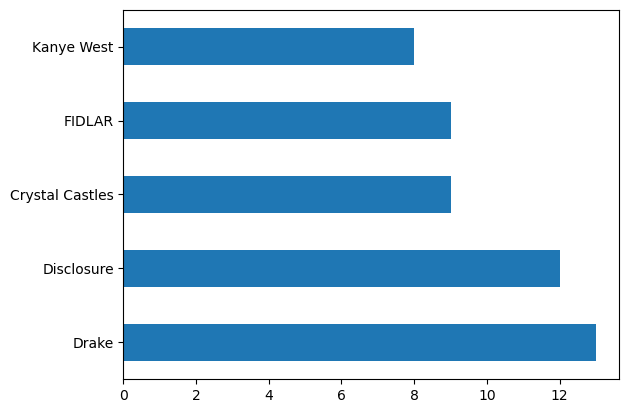

In [365]:
#Most occuring artist where target is 1
df[df['target']==1]['artist'].value_counts().head()
#Plot a graph
df[df['target']==1]['artist'].value_counts().head().plot(kind='barh')

## Top 5 Artist (Disliked Songs)

In [366]:
#Most occuring artist where target is 1
df[df['target']==0]['artist'].value_counts().head()

Backstreet Boys    10
WALK THE MOON      10
Rick Ross           9
Fall Out Boy        8
Michael Jackson     8
Name: artist, dtype: int64

In [367]:
#Dataframe where target = 1
df_liked = df[df['target'] == 1]
#Dataframe where target = 0
df_disliked = df[df['target'] == 0]

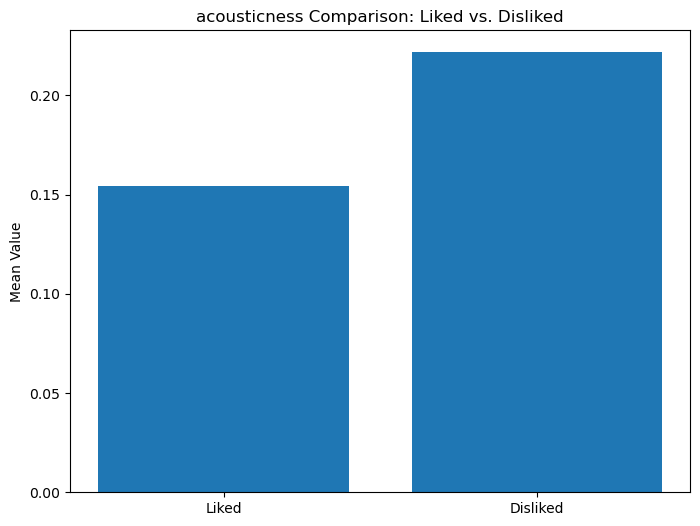

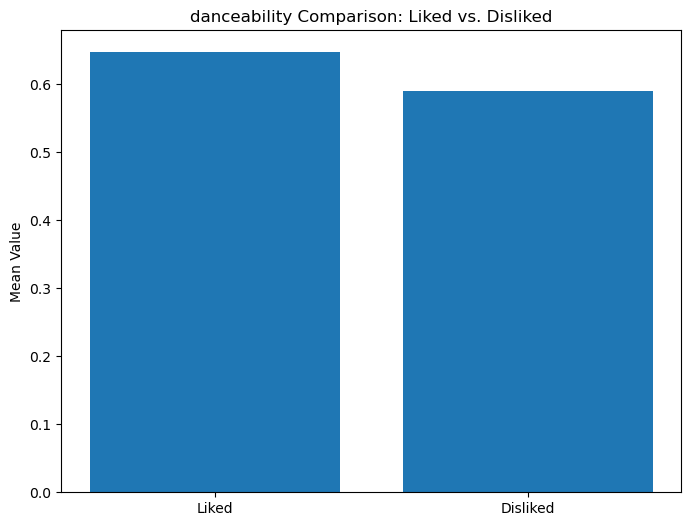

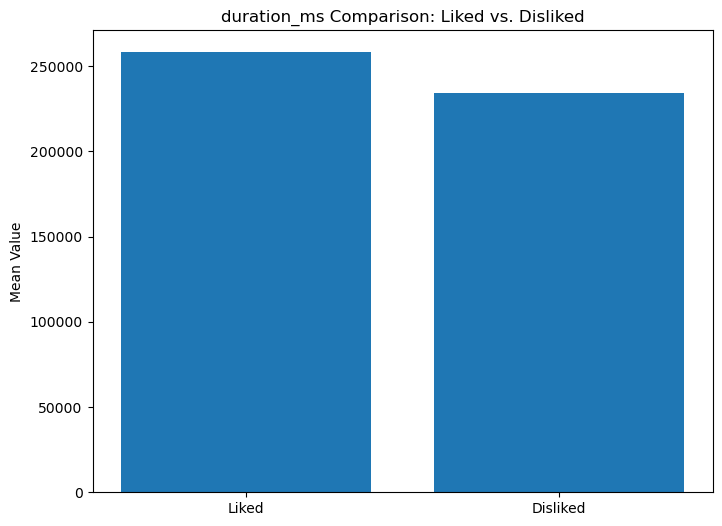

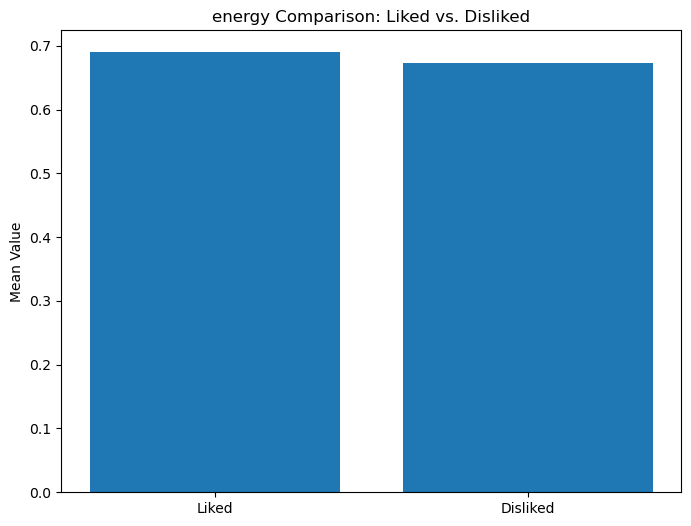

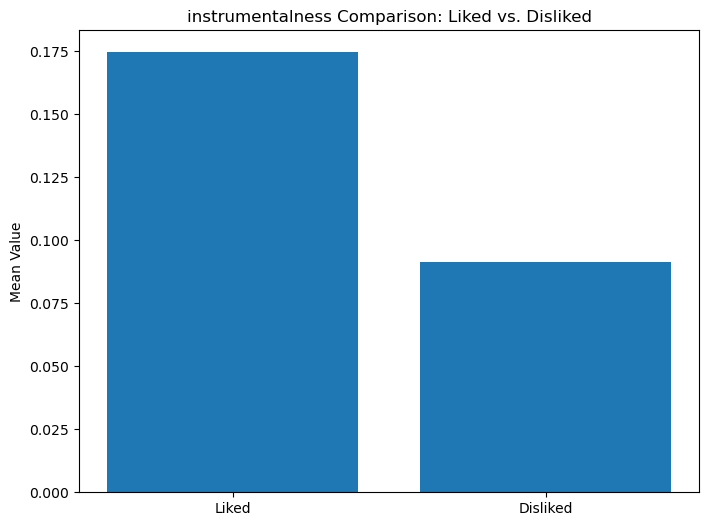

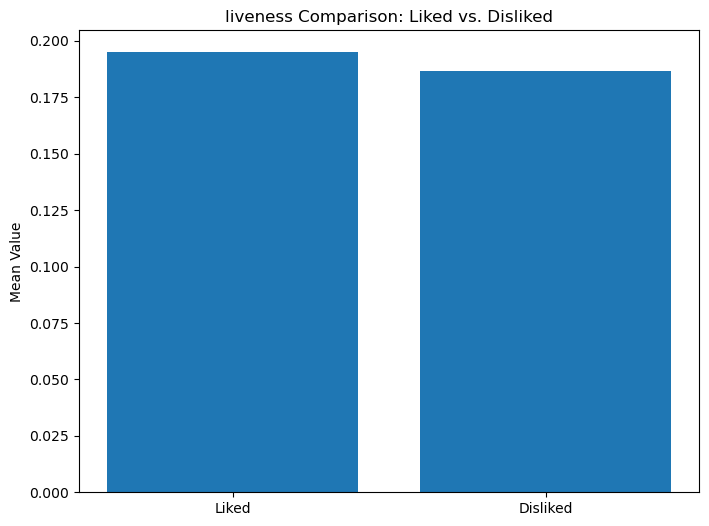

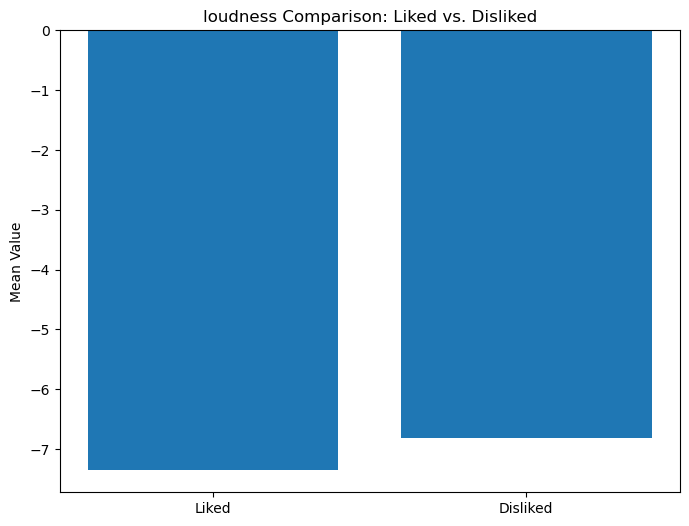

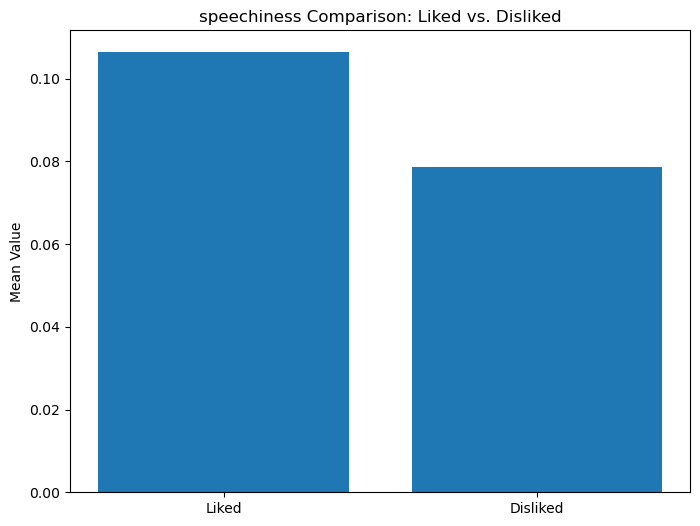

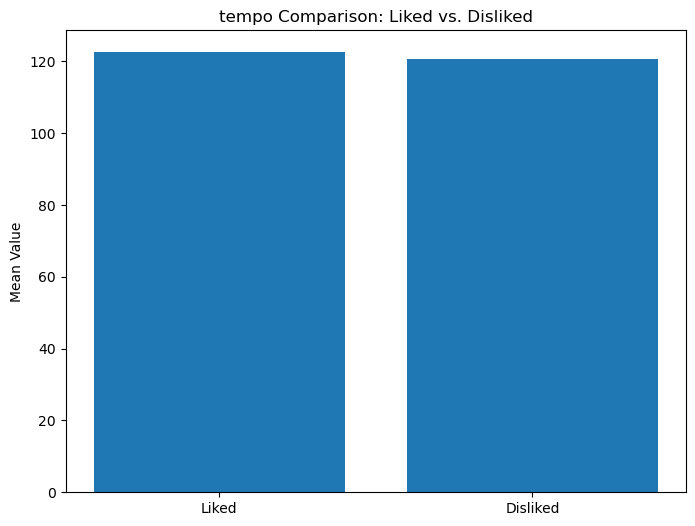

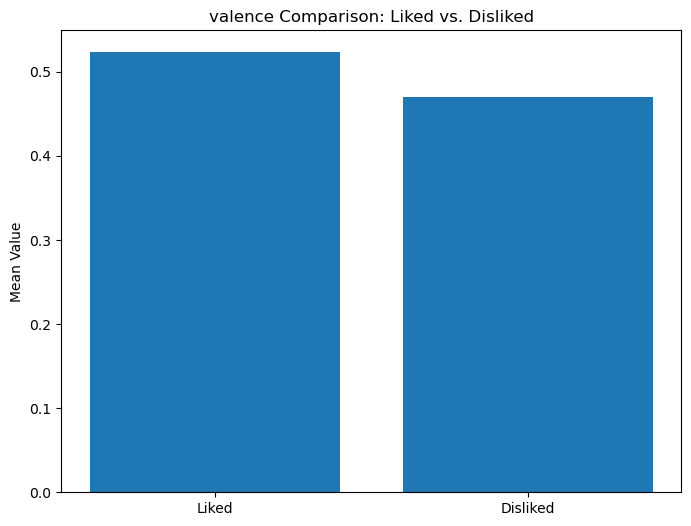

In [368]:
# Load your Spotify dataset
# Separate the dataset into liked and disliked songs

# Define the audio features to compare
audio_features = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']

# Calculate summary statistics for liked and disliked songs
liked_summary_stats = df_liked[audio_features].describe()
disliked_summary_stats = df_disliked[audio_features].describe()

# Visualize summary statistics using bar plots
for feature in audio_features:
    plt.figure(figsize=(8, 6))
    plt.bar(['Liked', 'Disliked'], [liked_summary_stats.loc['mean', feature], disliked_summary_stats.loc['mean', feature]])
    plt.title(f"{feature} Comparison: Liked vs. Disliked")
    plt.ylabel("Mean Value")
    plt.show()


In [369]:
# Define the audio features to compare
audio_features = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']

# Calculate summary statistics for liked and disliked songs
liked_summary_stats = df_liked[audio_features].describe()
disliked_summary_stats = df_disliked[audio_features].describe()

# Calculate percentage differences for each audio feature
percentage_differences = (liked_summary_stats.loc['mean'] - disliked_summary_stats.loc['mean']) / disliked_summary_stats.loc['mean'] * 100

# Display the percentage differences as a table
print("Percentage Differences between Liked and Disliked Songs:")
print(percentage_differences)


Percentage Differences between Liked and Disliked Songs:
acousticness       -30.401528
danceability         9.649676
duration_ms         10.274634
energy               2.479040
instrumentalness    91.458141
liveness             4.389510
loudness             7.950772
speechiness         35.208928
tempo                1.535938
valence             11.354957
Name: mean, dtype: float64


Text(0.5, 1.0, 'Negative Correlations')

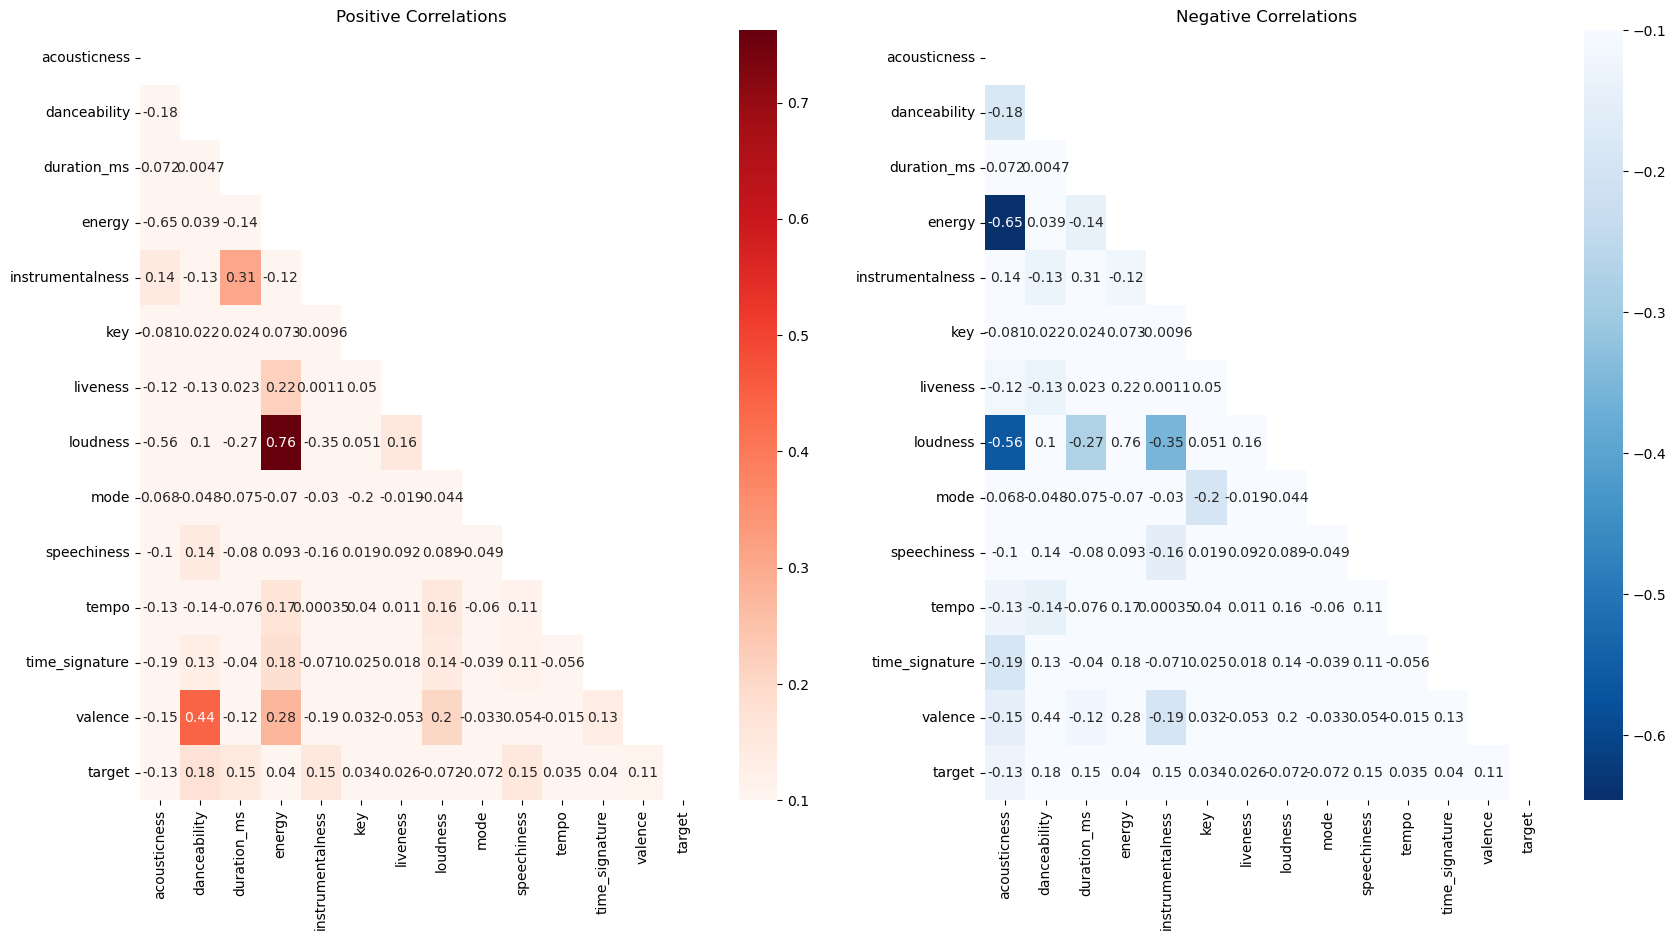

In [370]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(data= corr, annot=True, cmap ='Reds', ax = axes[0], mask = mask, vmin= 0.1)
axes[0].set_title('Positive Correlations')
sns.heatmap(data= corr, annot=True, cmap ='Blues_r', ax = axes[1], mask = mask, vmax=-0.1)
axes[1].set_title('Negative Correlations')

Features that are highly correlated to each other (Threshold = 0.4):
1. accoustics vs energy (-0.65)
2. accoustics vs loudness (-0.56)
3. dancebility vs valence (0.44)
4. loudness vs energy (0.76)

Either choose: Energy or Accoustics or Loudness

Either choose: Dancebility or Valence

# Feature Selection

In [371]:
# Separate features and target variable
# Drop target, song_title and artist_name from features
X = df.drop(['target','song_title','artist'], axis=1)  # Features
y = df['target']  # Target variable

# Calculate Pearson correlation between features and target
correlation_scores = X.corrwith(y)

# Compute mutual information between features and target
mutual_info_scores = mutual_info_classif(X, y)

# Create a DataFrame to display correlation and mutual information scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Correlation': correlation_scores, 'Mutual Information': mutual_info_scores})

# Display the feature scores
print(feature_scores)


                           Feature  Correlation  Mutual Information
acousticness          acousticness    -0.129627            0.029059
danceability          danceability     0.176706            0.033798
duration_ms            duration_ms     0.146749            0.038268
energy                      energy     0.039688            0.017909
instrumentalness  instrumentalness     0.152594            0.037188
key                            key     0.033594            0.005952
liveness                  liveness     0.026364            0.000000
loudness                  loudness    -0.072000            0.049766
mode                          mode    -0.072336            0.019618
speechiness            speechiness     0.154006            0.018039
tempo                        tempo     0.034732            0.018400
time_signature      time_signature     0.040182            0.000000
valence                    valence     0.107930            0.011841


In [372]:
# Define the feature combinations and the corresponding feature choices
feature_combinations = {
    ('energy', 'acousticness', 'loudness'): None,
    ('danceability', 'valence'): None,
}

# Iterate through the feature combinations and choose the best feature
for combination in feature_combinations:
    max_score = 0
    chosen_feature = None
    
    for feature in combination:
        correlation_score = feature_scores[feature_scores['Feature'] == feature]['Correlation'].values[0]
        mutual_info_score = feature_scores[feature_scores['Feature'] == feature]['Mutual Information'].values[0]
        # Combine correlation and mutual information scores as desired (e.g., by taking the mean)
        combined_score = (correlation_score + mutual_info_score) / 2
        
        if combined_score > max_score:
            max_score = combined_score
            chosen_feature = feature
    
    feature_combinations[combination] = chosen_feature

# Print the chosen features for each combination
for combination, chosen_feature in feature_combinations.items():
    print(f"Chosen feature for {', '.join(combination)}: {chosen_feature}")


Chosen feature for energy, acousticness, loudness: energy
Chosen feature for danceability, valence: danceability


In [373]:
#Drop Accousticness and Loudness and Valence
df.drop(['acousticness','loudness','valence'], axis=1, inplace=True)

# Data Preprocessing

## Handling Missing Values

In [374]:
#Check if there is missing values
df.isnull().sum()

danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
mode                0
speechiness         0
tempo               0
time_signature      0
target              0
song_title          0
artist              0
dtype: int64

## Handling Duplications

In [375]:
def get_duplicate_songs(df):
    """
    Get the duplicated songs (based on 'song_title' and 'artist' columns) from the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to be checked.

    Returns:
        pd.DataFrame: A DataFrame containing the rows with duplicated 'Song Title' and 'Artist'.
    """
    subset_columns = ['song_title', 'artist']
    duplicated_mask = df.duplicated(subset=subset_columns, keep=False)
    duplicated_songs = df[duplicated_mask]
    return duplicated_songs

# Example usage:
# Assuming 'df' is your DataFrame containing the 'song_title' and 'artist' columns.
# For example, to get the duplicated songs in the DataFrame 'df':
# duplicated_songs_df = get_duplicate_songs(df)


In [376]:
# Check if 'song name' has duplications
duplications=get_duplicate_songs(df)
duplications['title_artist'] = duplications['song_title'] + ' BY ' + duplications['artist']
#Arrange based on identical songs)
duplications.sort_values(by=['title_artist'], inplace=True)
duplications['title_artist']

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20108\2506026607.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20108\2506026607.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1148                        1-800-273-8255 BY Logic
1489                        1-800-273-8255 BY Logic
156                               Acamar BY Frankey
320                               Acamar BY Frankey
50                             Annie BY Neon Indian
                           ...                     
571        What I Might Do - Club Mix BY Ben Pearce
78      Words I Don't Remember BY How To Dress Well
223     Words I Don't Remember BY How To Dress Well
690                         Work REMIX BY A$AP Ferg
731                         Work REMIX BY A$AP Ferg
Name: title_artist, Length: 69, dtype: object

In [377]:
#Only keep song_title and artist_name and title_artist columns
duplications = duplications[['song_title','artist','title_artist']]
#Change title_artist to all lowercase
duplications['title_artist'] = duplications['title_artist'].str.lower()
#Remove leading or trailing spaces
duplications['title_artist'] = duplications['title_artist'].str.strip()
duplications

,song_title,artist,title_artist
1148,1-800-273-8255,Logic,1-800-273-8255 by logic
1489,1-800-273-8255,Logic,1-800-273-8255 by logic
156,Acamar,Frankey,acamar by frankey
320,Acamar,Frankey,acamar by frankey
50,Annie,Neon Indian,annie by neon indian
...,...,...,...
571,What I Might Do - Club Mix,Ben Pearce,what i might do - club mix by ben pearce
78,Words I Don't Remember,How To Dress Well,words i don't remember by how to dress well
223,Words I Don't Remember,How To Dress Well,words i don't remember by how to dress well
690,Work REMIX,A$AP Ferg,work remix by a$ap ferg


In [378]:
#Print out unique values count of 'title_artist' column
print(duplications['title_artist'].unique())
print(duplications['title_artist'].nunique())

['1-800-273-8255 by logic' 'acamar by frankey' 'annie by neon indian'
 'char by crystal castles' 'civilization by justice'
 'coming home by leon bridges' 'despacito - remix by luis fonsi'
 'episode i - duel of the fates by john williams' 'get lucky by daft punk'
 'her fantasy by matthew dear' "hold on, we're going home by drake"
 "i know there's gonna be (good times) by jamie xx"
 'i want it that way by backstreet boys' 'jack by breach'
 'look at wrist by father' 'mmmbop by hanson' 'mask off by future'
 'midnight city by m83' 'myth by beach house'
 'night on bald mountain by modest mussorgsky' 'obedear by purity ring'
 'outro by m83' 'pyramids by frank ocean' 'recover by chvrches'
 'river by ibeyi' 'shabba by a$ap ferg' 'sunshine of your love by cream'
 'swimming pools (drank) - extended version by kendrick lamar'
 "tearin' up my heart - radio edit by *nsync"
 'the daily mail by radiohead' 'the gaudy side of town by gayngs'
 'what i might do - club mix by ben pearce'
 "words i don't re

In [379]:
# Drop duplicates
df= df.drop_duplicates(subset=['song_title', 'artist'], keep='first')
#Reset index
df = df.reset_index(drop=True)
df

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
0,0.833,204600,0.434,0.021900,2,0.1650,1,0.4310,150.062,4.0,1,Mask Off,Future
1,0.743,326933,0.359,0.006110,1,0.1370,1,0.0794,160.083,4.0,1,Redbone,Childish Gambino
2,0.838,185707,0.412,0.000234,2,0.1590,1,0.2890,75.044,4.0,1,Xanny Family,Future
3,0.494,199413,0.338,0.510000,5,0.0922,1,0.0261,86.468,4.0,1,Master Of None,Beach House
4,0.678,392893,0.561,0.512000,5,0.4390,0,0.0694,174.004,4.0,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,0.584,274404,0.932,0.002690,1,0.1290,1,0.3330,74.976,4.0,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
1978,0.894,182182,0.892,0.001670,1,0.0528,1,0.1310,110.041,4.0,0,Candy,Dillon Francis
1979,0.637,207200,0.935,0.003990,0,0.2140,1,0.1070,150.082,4.0,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
1980,0.557,185600,0.992,0.677000,1,0.0913,1,0.1330,150.011,4.0,0,First Contact,Twin Moons


Observations Left after Dropping Duplicates = 2017-69-34 = 1982 Left

## Handling Outliers

In [380]:
data_categorical=df[['key','mode','time_signature','target']]


#unique values in each column
print("Unique values in each column:")
print("----------------------------")
for col in data_categorical.columns:
    print(col,":",data_categorical[col].unique())
    print("----------------------------")
    

Unique values in each column:
----------------------------
key : [ 2  1  5  8 10 11  7  0  9  6  4  3]
----------------------------
mode : [1 0]
----------------------------
time_signature : [4. 3. 5. 1.]
----------------------------
target : [1 0]
----------------------------


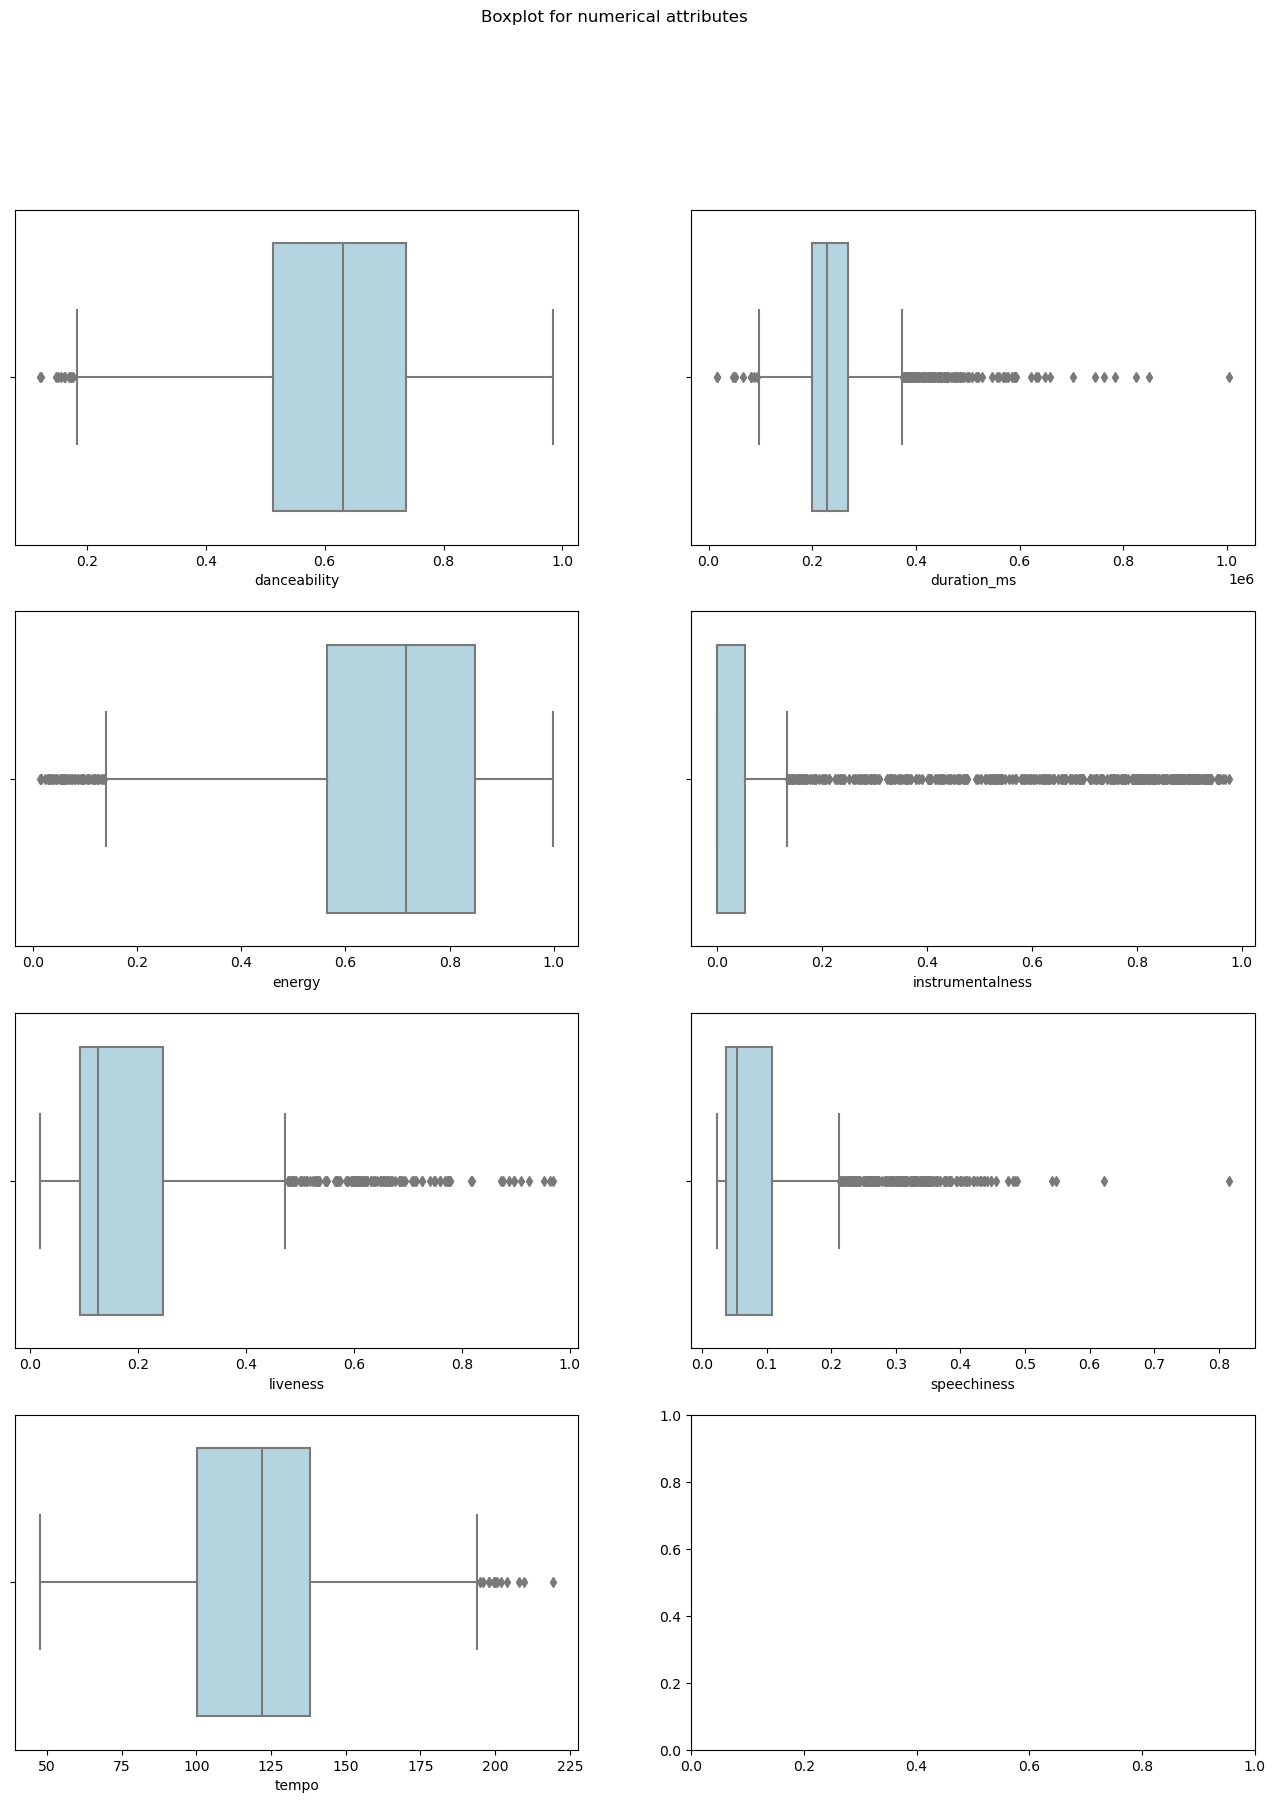

In [381]:
data_numerical=df[['danceability','duration_ms','energy','instrumentalness','liveness','speechiness','tempo']]

fig, axes = plt.subplots(4, 2, figsize = (16,20))
# fig1 , axes = plt.subplots(nrows=2,ncols=2 , figsize = (20,24))
axes = axes.flatten()
ax_no = 0
for col in data_numerical:
    p = sns.boxplot(data=df, x = col, ax = axes[ax_no] ,color='lightblue')
    ax_no += 1
fig.suptitle('Boxplot for numerical attributes')
plt.show()

### Locate Outliers 

In [382]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   lower_bound=q1-1.5*IQR
   upper_bound=q3+1.5*IQR

   outliers = df[((df<(lower_bound)) | (df>(upper_bound)))]

   return outliers

In [383]:
outliers = find_outliers_IQR(df)
#Rows with outliers
outliers=outliers.dropna(how='all')
outliers.head(20)

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.431,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.289,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,392893.0,NaN,0.512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.347,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,0.571,NaN,0.237,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,0.649,NaN,NaN,NaN,3.0,NaN,NaN,NaN
17,NaN,447907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.241,NaN,NaN,NaN,NaN,NaN


In [384]:
#Number of outliers
print("Number of outliers: ", len(outliers))

Number of outliers:  797


## Label Encode String Values 

In [385]:
# Initialize LabelEncoder objects
le_song_title = LabelEncoder()
le_artist = LabelEncoder()

# Create a temporary DataFrame with an extra "Unknown" category for song_title and artist
extra_row = pd.DataFrame([{'song_title': 'Unknown', 'artist': 'Unknown'}])
df_with_unknown = pd.concat([df, extra_row], ignore_index=True)

# Fit the LabelEncoder objects with the temporary DataFrame
le_song_title.fit(df_with_unknown['song_title'])
le_artist.fit(df_with_unknown['artist'])

# Transform the original DataFrame (this part remains unchanged)
df['song_title'] = le_song_title.transform(df['song_title'])
df['artist'] = le_artist.transform(df['artist'])

# Save the fitted LabelEncoders to disk
joblib.dump(le_song_title, 'label_encoder_song_title.pkl')
joblib.dump(le_artist, 'label_encoder_artist.pkl')


['label_encoder_artist.pkl']

## Dealing with Outliers

Deleting Rows with Outliers

In [386]:
#Method 1: Dropped Rows with outliers
df_rows_dropped = df.drop(outliers.index)
df_rows_dropped.head()

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
1,0.743,326933,0.359,0.006110,1,0.137,1,0.0794,160.083,4.0,1,1334,222
5,0.804,251333,0.560,0.000000,8,0.164,1,0.1850,85.023,4.0,1,1474,356
6,0.739,241400,0.472,0.000007,1,0.207,1,0.1560,80.030,4.0,1,318,356
11,0.753,324880,0.748,0.003480,10,0.212,1,0.0494,104.322,4.0,1,446,804
12,0.603,356973,0.434,0.061900,0,0.108,1,0.0342,127.681,4.0,1,299,398


In [387]:
print(df_rows_dropped.shape)

(1185, 13)


1107/1982 Rows = 0.5585 ≈ 45% Reduction of Observations (Undesirable)

Clipping

In [388]:
#Method 2: Capping Extreme Values to a specific Threshold
#Cap Maximum Value at 1.5 * IQR + Q3 and Minimum Value at Q1 - 1.5 * IQR
def clip(df):

    # Calculate Q1, Q3, and IQR for each numerical column
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1

    # Calculate lower and upper bounds for outlier replacement
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Replace extreme values with the bounds
    df_rows_clipped = df.clip(lower=lower_bound, upper=upper_bound)

    return df_rows_clipped

In [389]:
df_rows_clipped = df.copy()
# df_rows_clipped['acousticness'] = clip(df_rows_clipped['acousticness'])
# df_rows_clipped['loudness'] = clip(df_rows_clipped['loudness'])
df_rows_clipped['instrumentalness'] = clip(df_rows_clipped['instrumentalness'])
# df_rows_clipped['valence'] = clip(df_rows_clipped['valence'])
df_rows_clipped['danceability'] = clip(df_rows_clipped['danceability'])
df_rows_clipped['duration_ms'] = clip(df_rows_clipped['duration_ms'])
df_rows_clipped['energy'] = clip(df_rows_clipped['energy'])
df_rows_clipped['speechiness'] = clip(df_rows_clipped['speechiness'])
df_rows_clipped['liveness'] = clip(df_rows_clipped['liveness'])
df_rows_clipped['tempo'] = clip(df_rows_clipped['tempo'])
df_rows_clipped.head()

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
0,0.833,204600.00,0.434,0.021900,2,0.1650,1,0.21375,150.062,4.0,1,1043,449
1,0.743,326933.00,0.359,0.006110,1,0.1370,1,0.07940,160.083,4.0,1,1334,222
2,0.838,185707.00,0.412,0.000234,2,0.1590,1,0.21375,75.044,4.0,1,1907,449
3,0.494,199413.00,0.338,0.134938,5,0.0922,1,0.02610,86.468,4.0,1,1044,95
4,0.678,374918.75,0.561,0.134938,5,0.4390,0,0.06940,174.004,4.0,1,1243,628


### Scaling

Standardization

In [390]:
def standardize(df):
    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the StandardScaler on the DataFrame and transform the data
    scaled_data = scaler.fit_transform(df)

    # Create a new DataFrame with the scaled data and the same column names
    df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

    return df_scaled,scaler

In [391]:
# Select columns to standardize
columns_to_standardize = ['instrumentalness', 'danceability', 'duration_ms', 'energy', 'speechiness', 'liveness', 'tempo']
df_standardized = df.copy()

# Standardize selected columns
df_standardized[columns_to_standardize],fitted_scaler = standardize(df[columns_to_standardize])

# Save the fitted scaler for future use
joblib.dump(fitted_scaler, 'standard_scaler.pkl')

df_standardized.head()

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
0,1.336906,-0.505130,-1.185070,-0.407081,2,-0.162647,1,3.783613,1.062027,4.0,1,1043,449
1,0.776699,1.000153,-1.541980,-0.464963,1,-0.343116,1,-0.147269,1.437318,4.0,1,1334,222
2,1.368029,-0.737605,-1.289763,-0.486503,2,-0.201319,1,2.196055,-1.747430,4.0,1,1907,449
3,-0.773207,-0.568955,-1.641915,1.382156,5,-0.631866,1,-0.743163,-1.319596,4.0,1,1044,95
4,0.372105,1.811778,-0.580702,1.389487,5,1.603372,0,-0.259069,1.958666,4.0,1,1243,628


Availabe Dataframes: 
1. df (Removed Duplicated but outliers still present)
2. df_rows_dropped (Dropped Rows with outliers)
3. df_rows_clipped (Impute Outlier Values)
4. df_standardized (df after standardization scaling)

# Modelling

## Train Test Spilt

In [392]:
df.head()

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,target,song_title,artist
0,0.833,204600,0.434,0.021900,2,0.1650,1,0.4310,150.062,4.0,1,1043,449
1,0.743,326933,0.359,0.006110,1,0.1370,1,0.0794,160.083,4.0,1,1334,222
2,0.838,185707,0.412,0.000234,2,0.1590,1,0.2890,75.044,4.0,1,1907,449
3,0.494,199413,0.338,0.510000,5,0.0922,1,0.0261,86.468,4.0,1,1044,95
4,0.678,392893,0.561,0.512000,5,0.4390,0,0.0694,174.004,4.0,1,1243,628


In [393]:
#Train test spilt on df,df_rows_dropped,df_rows_clipped,df_standardized
X = df.drop(['target'], axis=True)
y= df['target']

#Train Test for original df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Test for df_rows_dropped
dropped_x = df_rows_dropped.drop('target', axis=1)
dropped_y = df_rows_dropped['target']
train_dropped_x, test_dropped_x, train_dropped_y, test_dropped_y = train_test_split(dropped_x, dropped_y, test_size=0.2, random_state=42)


#Train Test for df_rows_clipped
clipped_x = df_rows_clipped.drop('target', axis=1)
clipped_y = df_rows_clipped['target']
train_clipped_x, test_clipped_x, train_clipped_y, test_clipped_y = train_test_split(clipped_x, clipped_y, test_size=0.2, random_state=42)


#Train Test for df_standardized
standardized_x = df_standardized.drop('target', axis=1)
standardized_y = df_standardized['target']
train_standardized_x, test_standardized_x, train_standardized_y, test_standardized_y = train_test_split(standardized_x, standardized_y, test_size=0.2, random_state=42)

#make all train test sets into a list for easy access
train_x = [X_train,train_dropped_x, train_clipped_x, train_standardized_x]
train_y = [y_train,train_dropped_y, train_clipped_y, train_standardized_y]
test_x = [X_test,test_dropped_x, test_clipped_x, test_standardized_x]
test_y = [y_test,test_dropped_y, test_clipped_y, test_standardized_y]

## Extreme Gradient Boosting

In [394]:
#pip install xgboost

In [395]:
#For loop to fit all train test sets xgb boost
# Train : 76.66% , Test : 72.80%. 
xgb = XGBClassifier(
    reg_alpha=0.9,  # Increased L1 regularization term to prevent overfitting
    reg_lambda=0.9,  # Increased L2 regularization term to prevent overfitting
    max_depth=2,  # Reduced maximum depth to control complexity
    learning_rate=0.03,  # Slightly reduced learning rate
    subsample=0.75,  # Reduced subsample fraction to add more regularization
    random_state=231, 
    verbosity=0,  
    eval_metric='mlogloss'
)

accuracy_scores=[]
prediction_list=[]
for i in range(len(train_x)):
    xgb.fit(train_x[i], train_y[i])
    y_pred = xgb.predict(test_x[i])
    predictions = [round(value) for value in y_pred]
    #Append predictions to list
    prediction_list.append(predictions)
    accuracy = accuracy_score(test_y[i], predictions)
    #Append accuracy scores to list
    accuracy_scores.append(accuracy)

print("Accuracy Scores:")
print("df : %.2f%%" % (accuracy_scores[0] * 100))
print("df_rows_dropped : %.2f%%" % (accuracy_scores[1] * 100))
print("df_rows_clipped : %.2f%%" % (accuracy_scores[2] * 100))
print("df_standardized : %.2f%%" % (accuracy_scores[3] * 100))

#Print highest accuracy score
print("\nHighest Accuracy Score: %.2f%%" % (max(accuracy_scores) * 100))


Accuracy Scores:
df : 72.80%
df_rows_dropped : 70.89%
df_rows_clipped : 72.04%
df_standardized : 72.80%

Highest Accuracy Score: 72.80%


In [496]:
joblib.dump(xgb, 'xgb_Model.pkl')

['xgb_Model.pkl']

In [397]:
#Train XGB on standardized data
xgb.fit(train_standardized_x, train_standardized_y)
predictions_standardizedTrain = xgb.predict(train_standardized_x)
predictions_standardizedTest = xgb.predict(test_standardized_x)

accuracy_standardizedTrain = accuracy_score(train_standardized_y, predictions_standardizedTrain)
accuracy_standardizedTest = accuracy_score(test_standardized_y, predictions_standardizedTest)

print("Accuracy on Training (Standardized): %.2f%%" % (accuracy_standardizedTrain * 100))
print("Accuracy on Testing (Standardized): %.2f%%" % (accuracy_standardizedTest * 100))

Accuracy on Training (Standardized): 76.66%
Accuracy on Testing (Standardized): 72.80%


### Cross Validation

In [398]:
# Define the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate accuracy scores
accuracy_scores = cross_val_score(xgb, train_standardized_x, train_standardized_y, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores, start=1):
    print(f"Fold {fold}: Accuracy = {accuracy:.2f}")

# Calculate and print the mean and standard deviation of accuracy scores
mean_accuracy = accuracy_scores.mean()
std_accuracy = accuracy_scores.std()
print(f"Mean Accuracy = {mean_accuracy:.2f}")
print(f"Standard Deviation of Accuracy = {std_accuracy:.2f}")


Fold 1: Accuracy = 0.73
Fold 2: Accuracy = 0.74
Fold 3: Accuracy = 0.80
Fold 4: Accuracy = 0.74
Fold 5: Accuracy = 0.75
Fold 6: Accuracy = 0.75
Fold 7: Accuracy = 0.72
Fold 8: Accuracy = 0.75
Fold 9: Accuracy = 0.75
Fold 10: Accuracy = 0.66
Mean Accuracy = 0.74
Standard Deviation of Accuracy = 0.03


In [399]:

# Generate classification report
xgb_report = classification_report(test_standardized_y, predictions_standardizedTest)
print('\n Classification report: \n', xgb_report)

# Calculate accuracy score on test dataset
xgb_acc = accuracy_score(test_standardized_y, predictions_standardizedTest) * 100
print(f'Accuracy score on test dataset: {xgb_acc:.3f}%')


 Classification report: 
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       201
           1       0.72      0.73      0.73       196

    accuracy                           0.73       397
   macro avg       0.73      0.73      0.73       397
weighted avg       0.73      0.73      0.73       397

Accuracy score on test dataset: 72.796%


[[146  55]
 [ 53 143]]


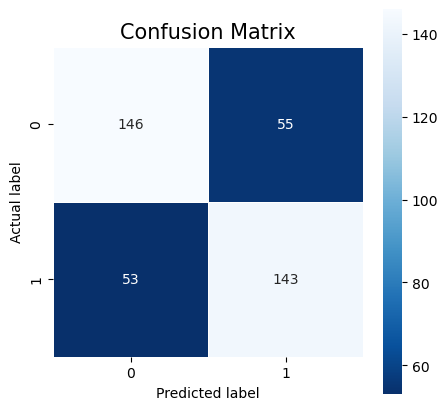

In [400]:
print(confusion_matrix(test_standardized_y, predictions_standardizedTest))
#Plot Confusion Matrix 
cm = confusion_matrix(test_standardized_y, predictions_standardizedTest)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()

# ROC

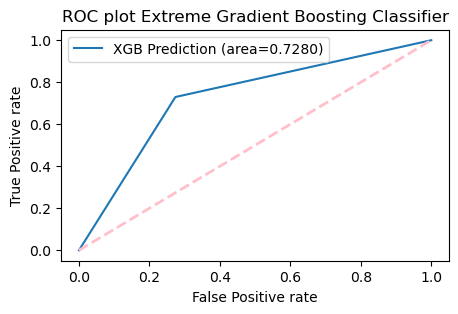

In [401]:
xgb_fpr,xgb_tpr,_=roc_curve(test_standardized_y, prediction_list[3])
xgb_auc=roc_auc_score(test_standardized_y, prediction_list[3])

# Plot Curve
plt.figure(figsize=(5,3))
plt.plot(xgb_fpr,xgb_tpr,label='XGB Prediction (area={:.4f})'.format(xgb_auc))

lw = 2
plt.plot([0,1], [0,1], color='pink', lw=lw, linestyle='--')

plt.title('ROC plot Extreme Gradient Boosting Classifier')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

# Gaussian Naive Bayes

In [402]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [403]:
gnb = GaussianNB()

In [404]:
#original data
#train set
gnb.fit(X_train, y_train)
print("train accuracy on df data")
gnb_y_pred_trainDF = gnb.predict(X_train)
train_accuracyDF = accuracy_score(y_train, gnb_y_pred_trainDF)
print("train set: %.4f%%" % (train_accuracyDF * 100.0))

#test set
gnb_y_pred_testDF = gnb.predict(X_test)
test_accuracyDF = accuracy_score(y_test, gnb_y_pred_testDF)
print("test set:%.4f%%" % (test_accuracyDF * 100.0))

train accuracy on df data
train set: 57.1609%
test set:54.4081%


In [405]:
# model fit on row drop with outliers
#train set
gnb.fit(train_dropped_x, train_dropped_y)
gnb_y_pred_trainDP = gnb.predict(train_dropped_x)
print("train accuracy on df_row_dropped data")
train_accuracyDP = accuracy_score(train_dropped_y, gnb_y_pred_trainDP)
print("train set: %.4f%%" % (train_accuracyDP * 100.0))

#test set
gnb_y_pred_testDP = gnb.predict(test_dropped_x)
test_accuracyDP = accuracy_score(test_dropped_y, gnb_y_pred_testDP)
print("test set: %.4f%%" % (test_accuracyDP * 100.0))

train accuracy on df_row_dropped data
train set: 63.8186%
test set: 62.4473%


In [406]:
# model fit on row clipped (Impute Outliers)
#train set
gnb.fit(train_clipped_x, train_clipped_y)
gnb_y_pred_trainCLP = gnb.predict(train_clipped_x)
print("train accuracy on df_rows_clipped data")
train_accuracyCLP = accuracy_score(train_clipped_y, gnb_y_pred_trainCLP)
print("train set: %.4f%%" % (train_accuracyCLP * 100.0))

#test set
gnb_y_pred_testCLP = gnb.predict(test_clipped_x)
test_accuracyCLP = accuracy_score(test_clipped_y, gnb_y_pred_testCLP)
print("test_set: %.4f%%" % (test_accuracyCLP * 100.0))

train accuracy on df_rows_clipped data
train set: 58.0442%
test_set: 57.1788%


In [407]:
# model fit on standardized data
#train set
gnb.fit(train_standardized_x, train_standardized_y)
gnb_y_pred_trainSTD = gnb.predict(train_standardized_x)
print("train accuracy on df_standardized data")
train_accuracySTD = accuracy_score(train_standardized_y, gnb_y_pred_trainSTD)
print("train set: %.4f%%" % (train_accuracySTD * 100.0))

#test set
gnb_y_pred_testSTD = gnb.predict(test_standardized_x)
test_accuracySTD = accuracy_score(test_standardized_y, gnb_y_pred_testSTD)
print("test set: %.4f%%" % (test_accuracySTD * 100.0))

train accuracy on df_standardized data
train set: 66.5615%
test set: 61.7128%


In [408]:
gnb_reportSTD = classification_report(test_standardized_y, gnb_y_pred_testSTD)
print('\n Classification report on standardized: \n', gnb_reportSTD)


 Classification report on standardized: 
               precision    recall  f1-score   support

           0       0.60      0.71      0.65       201
           1       0.64      0.52      0.57       196

    accuracy                           0.62       397
   macro avg       0.62      0.62      0.61       397
weighted avg       0.62      0.62      0.61       397



In [409]:
gnb_cm = confusion_matrix(test_standardized_y, gnb_y_pred_testSTD)
print('Confusion matrix on standardized: \n',gnb_cm)

Confusion matrix on standardized: 
 [[143  58]
 [ 94 102]]


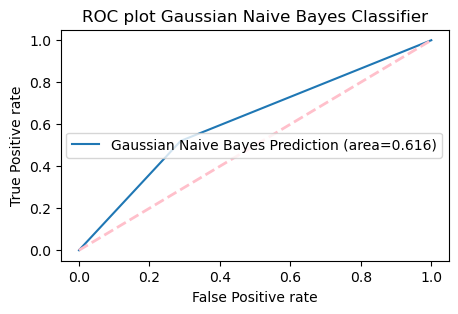

In [410]:
gnb_fpr,gnb_tpr,_=roc_curve(test_standardized_y, gnb_y_pred_testSTD)
gnb_auc=roc_auc_score(test_standardized_y, gnb_y_pred_testSTD)

# Plot Curve
plt.figure(figsize=(5,3))
plt.plot(gnb_fpr,gnb_tpr,label='Gaussian Naive Bayes Prediction (area={:.3f})'.format(gnb_auc))

lw = 2
plt.plot([0,1], [0,1], color='pink', lw=lw, linestyle='--')

plt.title('ROC plot Gaussian Naive Bayes Classifier')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### Gaussian Naive Bayes Tuning

#### Grid Search CV

In [516]:
# Define a range of alpha values to explore
alpha_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0]

# Create a parameter grid to search over
param_grid = {'var_smoothing': alpha_values}

# Perform grid search with cross-validation
grid_search = GridSearchCV(gnb, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_standardized_x, train_standardized_y)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['var_smoothing']
print("Best var_smoothing value:", best_alpha)
best_cv_accuracy = grid_search.best_score_
print("Best Cross-Validation Accuracy:", best_cv_accuracy)

# Train the final model with the best hyperparameters
gnb_tuning = GaussianNB(var_smoothing=best_alpha)
gnb_tuning.fit(train_standardized_x, train_standardized_y)

#accuracy
gnb_y_pred_train = gnb_tuning.predict(train_standardized_x)
train_accuracy = accuracy_score(train_standardized_y, gnb_y_pred_train)

gnb_y_pred_test = gnb_tuning.predict(test_standardized_x)
test_accuracy = accuracy_score(test_standardized_y, gnb_y_pred_test)

print("Training Accuracy: %.4f%%" % (train_accuracy * 100.0)) 
print("Test Accuracy: %.4f%%" % (test_accuracy * 100.0)) 

# Save the model to a file
joblib.dump(gnb_tuning, 'gnb_model.pkl')

Best var_smoothing value: 1e-08
Best Cross-Validation Accuracy: 0.6624950242815062
Training Accuracy: 66.6246%
Test Accuracy: 62.2166%


['gnb_model.pkl']

##### Classification Report using Grid SearchCV

In [412]:
gnb_tuneCV_report = metrics.classification_report(test_standardized_y, gnb_y_pred_test)
print('\n Classification report(standardized data): \n',gnb_tuneCV_report)


 Classification report(standardized data): 
               precision    recall  f1-score   support

           0       0.61      0.72      0.66       201
           1       0.64      0.53      0.58       196

    accuracy                           0.62       397
   macro avg       0.63      0.62      0.62       397
weighted avg       0.63      0.62      0.62       397



##### Confusion Matrix using Grid SearchCV

Confusion matrix on standardized: 
 [[144  57]
 [ 93 103]]


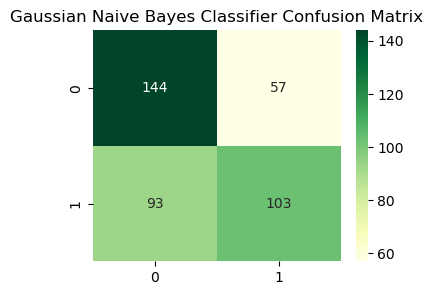

In [413]:
gnb_cm_tuneCV = confusion_matrix(test_standardized_y, gnb_y_pred_test)
print('Confusion matrix on standardized: \n',gnb_cm_tuneCV)

#Heatmap
plt.figure(figsize=(4,3))
plt.title("Gaussian Naive Bayes Classifier Confusion Matrix")
sns.heatmap(gnb_cm_tuneCV,annot=True,fmt='.5g',cmap="YlGn") 
plt.show()

##### ROC Curve using Grid SearchCV

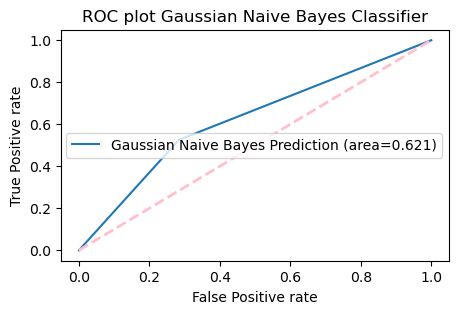

In [414]:
gnb_fpr,gnb_tpr,_=roc_curve(test_standardized_y, gnb_y_pred_test)
gnb_auc=roc_auc_score(test_standardized_y, gnb_y_pred_test)

# Plot Curve
plt.figure(figsize=(5,3))
plt.plot(gnb_fpr,gnb_tpr,label='Gaussian Naive Bayes Prediction (area={:.3f})'.format(gnb_auc))

lw = 2
plt.plot([0,1], [0,1], color='pink', lw=lw, linestyle='--')

plt.title('ROC plot Gaussian Naive Bayes Classifier')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

#### Repeated Stratified KFold

In [415]:
# Fit the transformer on training data
from sklearn.preprocessing import PowerTransformer

# Fit the transformer on training data
power_transformer = PowerTransformer()
train_transformed = power_transformer.fit_transform(train_standardized_x)
test_transformed = power_transformer.transform(test_standardized_x)  # Note the use of transform, not fit_transform

# Parameter grid
alpha_values = np.logspace(0,-9, num=100)
param_grid = {'var_smoothing': alpha_values}

# Cross-validation method
cv_method = RepeatedStratifiedKFold(n_splits=25, n_repeats=5, random_state=999)

# Grid Search
gs_NB = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=cv_method, verbose=1, scoring='accuracy')
gs_NB.fit(train_transformed, train_standardized_y)

# Results
best_alpha = gs_NB.best_params_['var_smoothing']
print("Best var_smoothing value:", best_alpha)
best_cv_accuracy = gs_NB.best_score_
print("Best Cross-Validation Accuracy:", best_cv_accuracy)

# Make predictions on the transformed data
gnb_y_pred_trainRSK = gs_NB.predict(train_transformed)
train_accuracyRSK = accuracy_score(train_standardized_y, gnb_y_pred_trainRSK)

gnb_y_pred_testRSK = gs_NB.predict(test_transformed)
test_accuracyRSK = accuracy_score(test_standardized_y, gnb_y_pred_testRSK)

print("Training Accuracy: %.4f%%" % (train_accuracyRSK * 100.0))
print("Test Accuracy: %.4f%%" % (test_accuracyRSK * 100.0))

Fitting 125 folds for each of 100 candidates, totalling 12500 fits


Best var_smoothing value: 0.3511191734215131
Best Cross-Validation Accuracy: 0.6721726190476189
Training Accuracy: 67.8233%
Test Accuracy: 63.2242%


In [416]:
# Save the Gaussian Naive Bayes Model
joblib.dump(gs_NB.best_estimator_, 'gaussian_naive_bayes_model.pkl')
# Save the Power Transformer
joblib.dump(power_transformer, 'power_transformer.pkl')

['power_transformer.pkl']

In [417]:
gnb_tuneRSK_report = metrics.classification_report(test_standardized_y, gnb_y_pred_testRSK)
print('\n Classification report: \n',gnb_tuneRSK_report)


 Classification report: 
               precision    recall  f1-score   support

           0       0.63      0.66      0.65       201
           1       0.63      0.60      0.62       196

    accuracy                           0.63       397
   macro avg       0.63      0.63      0.63       397
weighted avg       0.63      0.63      0.63       397



Confusion matrix on standardized: 
 [[133  68]
 [ 78 118]]


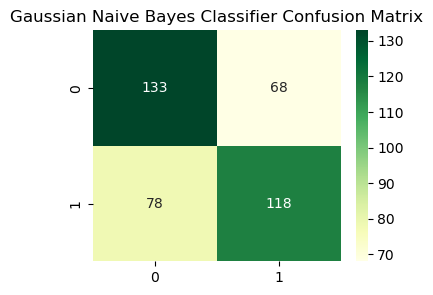

In [418]:
gnb_cm_tuneRSK = confusion_matrix(test_standardized_y, gnb_y_pred_testRSK)
print('Confusion matrix on standardized: \n',gnb_cm_tuneRSK)

# #Heatmap
plt.figure(figsize=(4,3))
plt.title("Gaussian Naive Bayes Classifier Confusion Matrix")
sns.heatmap(gnb_cm_tuneRSK,annot=True,fmt='.5g',cmap="YlGn") 
plt.show()

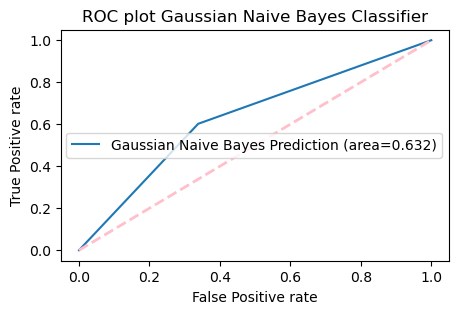

In [419]:
gnb_fpr,gnb_tpr,_=roc_curve(test_standardized_y, gnb_y_pred_testRSK)
gnb_auc=roc_auc_score(test_standardized_y, gnb_y_pred_testRSK)

# Plot Curve
plt.figure(figsize=(5,3))
plt.plot(gnb_fpr,gnb_tpr,label='Gaussian Naive Bayes Prediction (area={:.3f})'.format(gnb_auc))

lw = 2
plt.plot([0,1], [0,1], color='pink', lw=lw, linestyle='--')

plt.title('ROC plot Gaussian Naive Bayes Classifier')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

#### Grid Search with pipline and PCA

In [420]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Create the pipeline
pipe = Pipeline(steps=[
    ('pca', PCA()),  # You can configure PCA as needed
    ('estimator', gnb),
])

parameters = {'estimator__var_smoothing': np.logspace(0, -9, num=100)}

# Run GridSearchCV
Bayes = GridSearchCV(pipe, parameters, scoring='accuracy', cv=10).fit(train_standardized_x, train_standardized_y)

print(Bayes.best_estimator_)
print('best score:', Bayes.best_score_)
print('best params:', Bayes.best_params_)

# Make predictions on the test data
test_predictions = Bayes.best_estimator_.predict(test_standardized_x)

# Calculate accuracy scores on train and test data
train_predictions = Bayes.best_estimator_.predict(train_standardized_x)
train_accuracy = accuracy_score(train_standardized_y, train_predictions)
test_accuracy = accuracy_score(test_standardized_y, test_predictions)

print("Training Accuracy:  %.4f%%" % (train_accuracy * 100.0)) 
print("Test Accuracy: %.4f%%" % (test_accuracy * 100.0)) 


Pipeline(steps=[('pca', PCA()),
                ('estimator', GaussianNB(var_smoothing=6.579332246575682e-07))])
best score: 0.6448172916169094
best params: {'estimator__var_smoothing': 6.579332246575682e-07}
Training Accuracy:  64.9842%
Test Accuracy: 61.4610%


In [421]:
gnb_tunePCA_report = metrics.classification_report(test_standardized_y, test_predictions)
print('\n Classification report: \n',gnb_tunePCA_report)


 Classification report: 
               precision    recall  f1-score   support

           0       0.60      0.75      0.66       201
           1       0.65      0.48      0.55       196

    accuracy                           0.61       397
   macro avg       0.62      0.61      0.61       397
weighted avg       0.62      0.61      0.61       397



##### Confusion Matrix using Grid Search with pipline and PCA

Confusion matrix on standardized: 
 [[150  51]
 [102  94]]


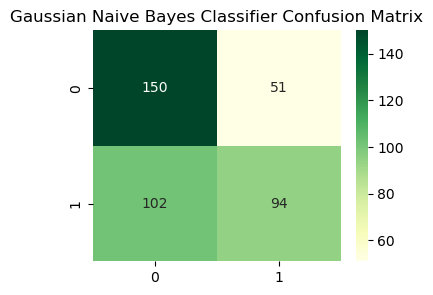

In [422]:
gnb_cm_tunePCA = confusion_matrix(test_standardized_y, test_predictions)
print('Confusion matrix on standardized: \n',gnb_cm_tunePCA)

# #Heatmap
plt.figure(figsize=(4,3))
plt.title("Gaussian Naive Bayes Classifier Confusion Matrix")
sns.heatmap(gnb_cm_tunePCA,annot=True,fmt='.5g',cmap="YlGn") 
plt.show()

##### ROC Curve using Grid Search with pipline and PCA

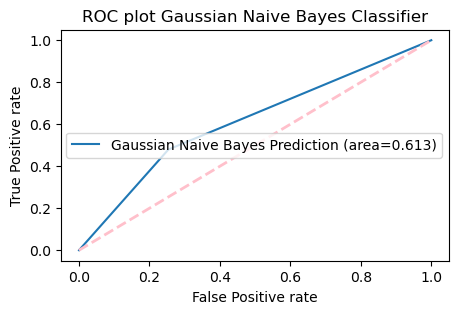

In [423]:
gnb_fpr,gnb_tpr,_=roc_curve(test_standardized_y, test_predictions)
gnb_auc=roc_auc_score(test_standardized_y, test_predictions)

# Plot Curve
plt.figure(figsize=(5,3))
plt.plot(gnb_fpr,gnb_tpr,label='Gaussian Naive Bayes Prediction (area={:.3f})'.format(gnb_auc))

lw = 2
plt.plot([0,1], [0,1], color='pink', lw=lw, linestyle='--')

plt.title('ROC plot Gaussian Naive Bayes Classifier')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

#### RandomSearch

In [424]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define a distribution to sample from
param_dist = {'var_smoothing': uniform(1e-9, 1e-1)}

# Create a RandomizedSearchCV object and fit it to the data
random_search = RandomizedSearchCV(gnb, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')
random_search.fit(train_standardized_x, train_standardized_y)

# Get the best hyperparameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Train a new Gaussian Naive Bayes model using the best hyperparameters
best_gnb = GaussianNB(var_smoothing=best_params['var_smoothing'])
best_gnb.fit(train_standardized_x, train_standardized_y)

#accuracy
gnb_y_pred_train = best_gnb.predict(train_standardized_x)
train_accuracy = accuracy_score(train_standardized_y, gnb_y_pred_train)

gnb_y_pred_test = best_gnb.predict(test_standardized_x)
test_accuracy = accuracy_score(test_standardized_y, gnb_y_pred_test)

print("Training Accuracy: %.4f%%" % (train_accuracy * 100.0)) 
print("Test Accuracy: %.4f%%" % (test_accuracy * 100.0)) 

Training Accuracy: 52.3028%
Test Accuracy: 40.8060%


# Random Forest

In [489]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=8,
    min_samples_leaf=6,
    max_features=0.8,
    random_state=42,
    bootstrap=True
)

# Fit the classifier to your data (X_train and y_train are assumed to be your training data)
rf_classifier.fit(train_standardized_x, train_standardized_y)

# Save the model
joblib.dump(rf_classifier, 'rf_model.pkl')

forest_y_train_pred = rf_classifier.predict(train_standardized_x)

# Now you can use the trained classifier for predictions
forest_y_pred = rf_classifier.predict(test_standardized_x)

In [426]:
trainAcc = accuracy_score(train_standardized_y,forest_y_train_pred)*100
print('Accuracy Score on train y = ',trainAcc)

rf_acc = accuracy_score(test_standardized_y,forest_y_pred)*100
print(f'Accuracy_score on test dataset : {rf_acc:.3f}' )

print("Diff : ", trainAcc - rf_acc)

Accuracy Score on train y =  82.71293375394322
Accuracy_score on test dataset : 73.048
Diff :  9.66507481187773


## Tuning for Random Forest

In [427]:
rf = RandomForestClassifier(random_state=42)

In [428]:
# Number of trees in random forest
n_estimators = [x for x in range(100, 501, 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.8, 1, 0.5]
# Maximum number of levels in tree
max_depth = [5,6,8,10,12]
# max_depth = [5,15]
# Minimum number of samples required to split a node
min_samples_split = [4,6,8,10,12]
# min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,6,8,10,12]
# min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [429]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid

{'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt', 0.8, 1, 0.5],
 'max_depth': [5, 6, 8, 10, 12],
 'min_samples_split': [4, 6, 8, 10, 12],
 'min_samples_leaf': [4, 6, 8, 10, 12],
 'bootstrap': [True, False]}

In [430]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=2, verbose=2, n_jobs=3)
grid_search

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=3,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 6, 8, 10, 12],
                         'max_features': ['auto', 'sqrt', 0.8, 1, 0.5],
                         'min_samples_leaf': [4, 6, 8, 10, 12],
                         'min_samples_split': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='accuracy', verbose=2)

In [431]:
# grid_search.fit(train_standardized_x, train_standardized_y)
# grid_search 

#75 mins to run (dont do it again pls)

In [432]:
# grid_search.best_score_

In [433]:
# best_rf = grid_search.best_estimator_  # or randomized_search.best_estimator_
# y_pred = best_rf.predict(test_standardized_x)

# y_pred_acc = accuracy_score(test_standardized_y, y_pred)*100
# print("test Acc. = ", y_pred_acc)

# #Y trian
# y_pred_train = best_rf.predict(train_standardized_x)
# y_pred_train_acc = accuracy_score(train_standardized_y, y_pred_train)*100
# print("train Acc. = ", y_pred_train_acc)

# print("Diff : ", y_pred_train_acc - y_pred_acc)

# print("~20% diff. not good.")


In [434]:
# best_params = grid_search.best_params_
# print(best_params)
# best_score = grid_search.best_score_
# print(best_score)

In [435]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
num_folds = 10

# Create a k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate accuracy scores
accuracy_scores = cross_val_score(rf_classifier, train_standardized_x, train_standardized_y, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores, start=1):
    print(f"Fold {fold}: Accuracy = {accuracy:.2f}")

# Calculate and print the mean and standard deviation of accuracy scores
mean_accuracy = accuracy_scores.mean()
std_accuracy = accuracy_scores.std()
print(f"Mean Accuracy = {mean_accuracy:.2f}")
print(f"Standard Deviation of Accuracy = {std_accuracy:.2f}")

Fold 1: Accuracy = 0.77
Fold 2: Accuracy = 0.79
Fold 3: Accuracy = 0.81
Fold 4: Accuracy = 0.75
Fold 5: Accuracy = 0.81
Fold 6: Accuracy = 0.72
Fold 7: Accuracy = 0.69
Fold 8: Accuracy = 0.78
Fold 9: Accuracy = 0.72
Fold 10: Accuracy = 0.71
Mean Accuracy = 0.75
Standard Deviation of Accuracy = 0.04


## Evaluation

In [436]:
# print("Diff : ", trainAcc - rf_acc)
# print("Diff(GridSearchCv best param) : ", y_pred_train_acc - y_pred_acc)

# print("take origina param")
# print("Accuracy Score on Test = ", rf_acc)

# Sheng Hao

In [437]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import StackingClassifier


In [438]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# KNN

In [439]:
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the model on the training data
knn_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training data
y_train_pred = knn_classifier.predict(train_standardized_x)

# Calculate training accuracy
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)

# Make predictions on the testing data
y_pred = knn_classifier.predict(test_standardized_x)

# Calculate test accuracy
test_accuracy = accuracy_score(test_standardized_y, y_pred)

# Print both training and test accuracy
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.7186119873817035
Test Accuracy: 0.5062972292191436


In [440]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 19, 23, 29],
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(train_standardized_x, train_standardized_y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Create the best KNN classifier with the best parameters
best_knn = KNeighborsClassifier(**grid_search.best_params_)

# Fit the best KNN model on the training data
best_knn.fit(train_standardized_x, train_standardized_y)

# Predict on the training and test sets
y_train_pred = best_knn.predict(train_standardized_x)
y_test_pred = best_knn.predict(test_standardized_x)

# Calculate accuracy
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

# Print accuracies
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'n_neighbors': 11}
Best Score: 0.5621451104100946
Training Accuracy: 0.6529968454258676
Test Accuracy: 0.5214105793450882


In [441]:
knn = confusion_matrix(test_standardized_y,y_test_pred)
knn

array([[115,  86],
       [104,  92]], dtype=int64)

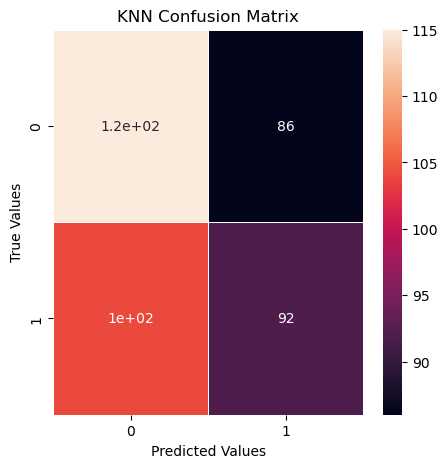

In [442]:
plt.subplots(figsize=(5,5))

sns.heatmap(knn,annot=True,linewidths=0.5)

plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [443]:
y_true_dt, y_pred_dt = test_standardized_y, y_test_pred
print(classification_report(y_true_dt, y_pred_dt))

knn_pre = precision_score(y_true_dt, y_pred_dt) * 100
knn_rec = recall_score(y_true_dt, y_pred_dt) * 100
knn_f1 = f1_score(y_true_dt, y_pred_dt) * 100

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       201
           1       0.52      0.47      0.49       196

    accuracy                           0.52       397
   macro avg       0.52      0.52      0.52       397
weighted avg       0.52      0.52      0.52       397



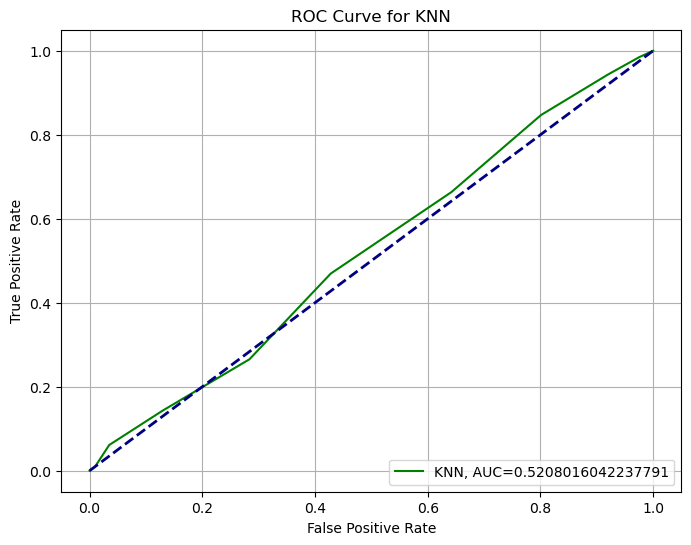

In [444]:
# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_dt = best_knn.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_dt, tpr_dt, _ = roc_curve(test_standardized_y, y_pred_proba_dt)

# Calculate the AUC score
dt_auc = roc_auc_score(test_standardized_y, y_pred_proba_dt)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label="KNN, AUC=" + str(dt_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for KNN")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# Start experiment for stacking algorithm

# Decision tree 

In [445]:
# Create a Decision Tree classifier with a random state
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
decision_tree_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training data
y_train_pred = decision_tree_classifier.predict(train_standardized_x)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)

# Make predictions on the testing data
y_test_pred = decision_tree_classifier.predict(test_standardized_x)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.6372795969773299


In [446]:
# Define the parameter grid
param_grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

# Create a Decision Tree classifier
tree_clas = DecisionTreeClassifier(random_state=1024)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)

# Fit the grid search to your data
grid_search.fit(train_standardized_x, train_standardized_y)

# Get the best parameters and estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the testing data using the best estimator
y_test_pred = best_estimator.predict(test_standardized_x)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

print("Best Parameters:", best_params)

# No need to explicitly create a Decision Tree classifier with the best parameters
# The best_estimator already has the best parameters

# Make predictions on the training data
y_train_pred = best_estimator.predict(train_standardized_x)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)

# Print accuracies and best parameters
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Fitting 5 folds for each of 294 candidates, totalling 1470 fits


Best Parameters: {'max_leaf_nodes': 16, 'min_samples_split': 2}
Training Accuracy: 0.7634069400630915
Test Accuracy: 0.6851385390428212


In [447]:
dt = confusion_matrix(test_standardized_y,y_test_pred)
dt

array([[138,  63],
       [ 62, 134]], dtype=int64)

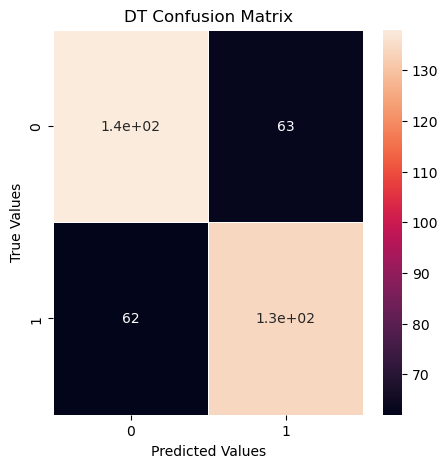

In [448]:
plt.subplots(figsize=(5,5))

sns.heatmap(dt,annot=True,linewidths=0.5)

plt.title("DT Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [449]:
y_true_dt, y_pred_dt = test_standardized_y, y_test_pred
print(classification_report(y_true_dt, y_pred_dt))

dt_pre = precision_score(y_true_dt, y_pred_dt) * 100
dt_rec = recall_score(y_true_dt, y_pred_dt) * 100
dt_f1 = f1_score(y_true_dt, y_pred_dt) * 100

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       201
           1       0.68      0.68      0.68       196

    accuracy                           0.69       397
   macro avg       0.69      0.69      0.69       397
weighted avg       0.69      0.69      0.69       397



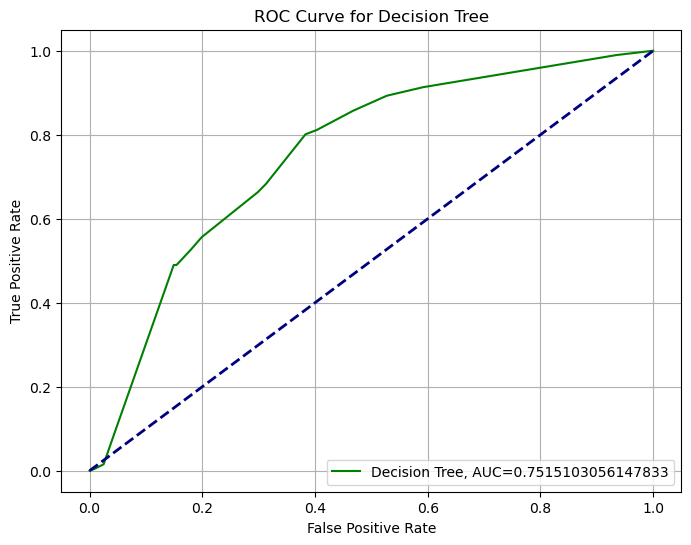

In [450]:
# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_dt = best_estimator.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_dt, tpr_dt, _ = roc_curve(test_standardized_y, y_pred_proba_dt)

# Calculate the AUC score
dt_auc = roc_auc_score(test_standardized_y, y_pred_proba_dt)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree, AUC=" + str(dt_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for Decision Tree")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# Logistic Regression

In [451]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=42)

# Train the model on the training data
logreg_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training data
y_train_pred = logreg_classifier.predict(train_standardized_x)

# Calculate training accuracy
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)

# Make predictions on the testing data
y_pred = logreg_classifier.predict(test_standardized_x)

# Calculate test accuracy
test_accuracy = accuracy_score(test_standardized_y, y_pred)

# Print both training and test accuracy
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.6618296529968454
Test Accuracy: 0.6020151133501259


In [452]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

# Create a logistic regression classifier
clf = LogisticRegression()

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_standardized_x, train_standardized_y)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to create a new logistic regression model
best_clf = LogisticRegression(**best_params)

# Fit the best model to the training data
best_clf.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training and test sets
y_train_pred = best_clf.predict(train_standardized_x)
y_test_pred = best_clf.predict(test_standardized_x)

# Calculate and print the accuracy on the training and test sets
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\ASUS\anaconda3\lib\site-packages\sk

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Training Accuracy: 0.6586750788643533
Test Accuracy: 0.5919395465994962


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\ASUS\anaconda3\lib\site-packages\sk

In [453]:
lr = confusion_matrix(test_standardized_y,y_test_pred)
lr

array([[124,  77],
       [ 85, 111]], dtype=int64)

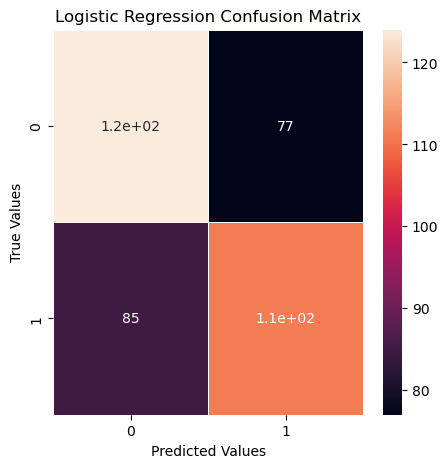

In [454]:
plt.subplots(figsize=(5,5))

sns.heatmap(lr,annot=True,linewidths=0.5)

plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [455]:
y_true_lr, y_pred_lr = test_standardized_y, y_test_pred
print(classification_report(y_true_lr, y_pred_lr))

lr_pre = precision_score(y_true_lr, y_pred_lr) * 100
lr_rec = recall_score(y_true_lr, y_pred_lr) * 100
lr_f1 = f1_score(y_true_lr, y_pred_lr) * 100

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       201
           1       0.59      0.57      0.58       196

    accuracy                           0.59       397
   macro avg       0.59      0.59      0.59       397
weighted avg       0.59      0.59      0.59       397



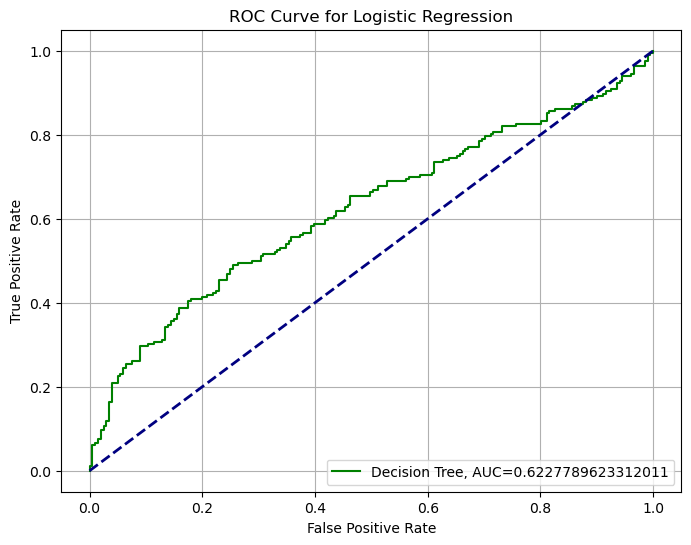

In [456]:
# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_lr = best_clf.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(test_standardized_y, y_pred_proba_lr)

# Calculate the AUC score
lr_auc = roc_auc_score(test_standardized_y, y_pred_proba_lr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Decision Tree, AUC=" + str(lr_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# SVM

In [457]:

# Create an SVM classifier
svm_classifier = SVC(random_state=42,probability=True)

# Train the model on the training data
svm_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training data
y_train_pred = svm_classifier.predict(train_standardized_x)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)

# Make predictions on the testing data
y_test_pred = svm_classifier.predict(test_standardized_x)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


Training Accuracy: 0.5318611987381704
Testing Accuracy: 0.43073047858942065


In [458]:
svm = confusion_matrix(test_standardized_y,y_test_pred)
svm

array([[ 53, 148],
       [ 78, 118]], dtype=int64)

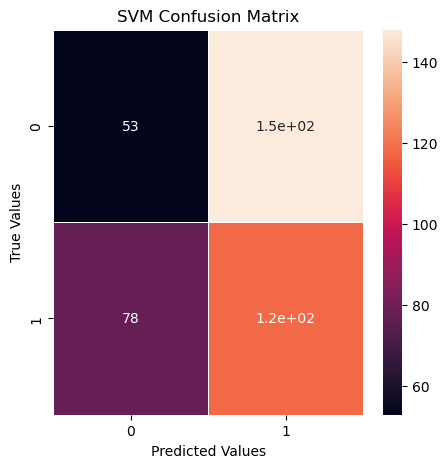

In [459]:
plt.subplots(figsize=(5,5))

sns.heatmap(svm,annot=True,linewidths=0.5)

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [460]:
y_true_svm, y_pred_svm = test_standardized_y, y_test_pred
print(classification_report(y_true_svm, y_pred_svm))

svm_pre = precision_score(y_true_svm, y_pred_svm) * 100
svm_rec = recall_score(y_true_svm, y_pred_svm) * 100
svm_f1 = f1_score(y_true_svm, y_pred_svm) * 100


              precision    recall  f1-score   support

           0       0.40      0.26      0.32       201
           1       0.44      0.60      0.51       196

    accuracy                           0.43       397
   macro avg       0.42      0.43      0.42       397
weighted avg       0.42      0.43      0.41       397



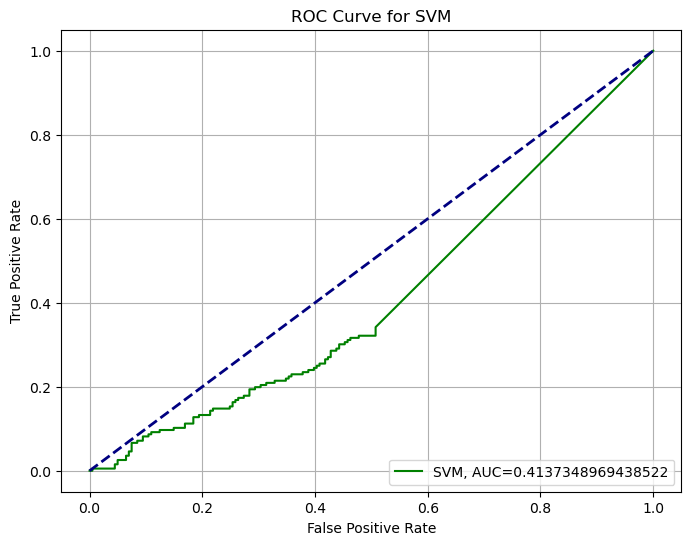

In [461]:


# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_svm = svm_classifier.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(test_standardized_y, y_pred_proba_svm)

# Calculate the AUC score
svm_auc = roc_auc_score(test_standardized_y, y_pred_proba_svm)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(svm_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for SVM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# Bernoulli Naive Bayes classifier

In [462]:

# Initialize the Bernoulli Naive Bayes classifier
bernoulli_nb_classifier = BernoulliNB()

# Train the model on the training data
bernoulli_nb_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training data
y_train_pred = bernoulli_nb_classifier.predict(train_standardized_x)

# Make predictions on the testing data
y_test_pred = bernoulli_nb_classifier.predict(test_standardized_x)

# Calculate accuracy for training and test sets
train_accuracy = accuracy_score(train_standardized_y, y_train_pred)
test_accuracy = accuracy_score(test_standardized_y, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.6410094637223974
Test Accuracy: 0.5994962216624685


In [463]:
bnb = confusion_matrix(test_standardized_y,y_test_pred)
bnb

array([[118,  83],
       [ 76, 120]], dtype=int64)

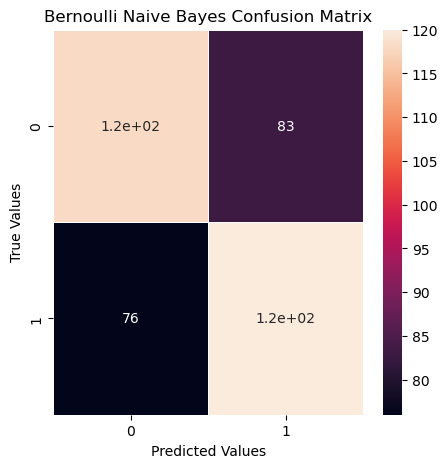

In [464]:
plt.subplots(figsize=(5,5))

sns.heatmap(bnb,annot=True,linewidths=0.5)

plt.title("Bernoulli Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [465]:
y_true_bnb, y_pred_bnb = test_standardized_y, y_test_pred
print(classification_report(y_true_bnb, y_pred_bnb))

bnb_pre = precision_score(y_true_bnb, y_pred_bnb) * 100
bnb_rec = recall_score(y_true_bnb, y_pred_bnb) * 100
bnb_f1 = f1_score(y_true_bnb, y_pred_bnb) * 100

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       201
           1       0.59      0.61      0.60       196

    accuracy                           0.60       397
   macro avg       0.60      0.60      0.60       397
weighted avg       0.60      0.60      0.60       397



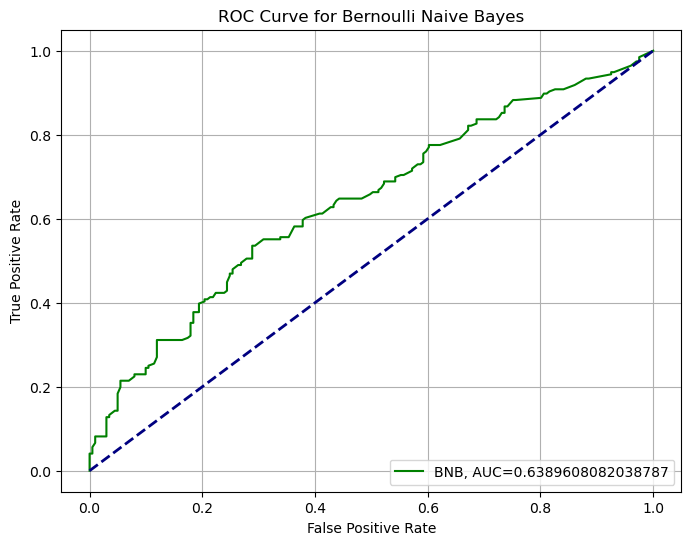

In [466]:
# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_bnb = bernoulli_nb_classifier.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_bnb, tpr_bnb, _ = roc_curve(test_standardized_y, y_pred_proba_bnb)

# Calculate the AUC score
bnb_auc = roc_auc_score(test_standardized_y, y_pred_proba_bnb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_bnb, tpr_bnb, label="BNB, AUC=" + str(bnb_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for Bernoulli Naive Bayes")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# Stacking Classifier (after experiment)

In [495]:
# Define the best parameters for Decision Tree and KNN
best_dt_params = {'max_leaf_nodes': 16, 'min_samples_split': 2}
best_knn_params = {'n_neighbors': 11}

# Initialize individual models with the best parameters
dt_classifier = DecisionTreeClassifier(**best_dt_params)
knn_classifier = KNeighborsClassifier(**best_knn_params)

# Create a list of tuples representing base estimators and their names
base_estimators = [
    ('decision_tree', dt_classifier),
    ('knn', knn_classifier)
]

# Initialize the StackingClassifier with base estimators and a final estimator
stacked_classifier = StackingClassifier(
    estimators=base_estimators,
    cv=5
)

# Fit the stacked ensemble model to the training data
stacked_classifier.fit(train_standardized_x, train_standardized_y)

# Make predictions on the training set using the stacked model
train_predictions = stacked_classifier.predict(train_standardized_x)

# Make predictions on the test set using the stacked model
test_predictions = stacked_classifier.predict(test_standardized_x)

# Calculate and print the training and test accuracies
train_accuracy = accuracy_score(train_standardized_y, train_predictions)
test_accuracy = accuracy_score(test_standardized_y, test_predictions)

print("Training Accuracy (Stacked Ensemble):", train_accuracy)
print("Test Accuracy (Stacked Ensemble):", test_accuracy)

# Save the model
joblib.dump(stacked_classifier, 'stacked_classifier.pkl')


Training Accuracy (Stacked Ensemble): 0.783596214511041
Test Accuracy (Stacked Ensemble): 0.7103274559193955


['stacked_classifier.pkl']

In [469]:
s = confusion_matrix(test_standardized_y,test_predictions)
s

array([[140,  61],
       [ 54, 142]], dtype=int64)

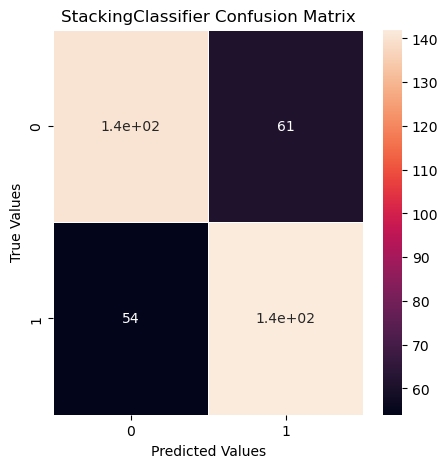

In [470]:
plt.subplots(figsize=(5,5))

sns.heatmap(s,annot=True,linewidths=0.5)

plt.title("StackingClassifier Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

plt.show()

In [471]:
y_true_s, y_pred_s = test_standardized_y, test_predictions
print(classification_report(y_true_s, y_pred_s))

s_pre = precision_score(y_true_s, y_pred_s) * 100
s_rec = recall_score(y_true_s, y_pred_s) * 100
s_f1 = f1_score(y_true_s, y_pred_s) * 100

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       201
           1       0.70      0.72      0.71       196

    accuracy                           0.71       397
   macro avg       0.71      0.71      0.71       397
weighted avg       0.71      0.71      0.71       397



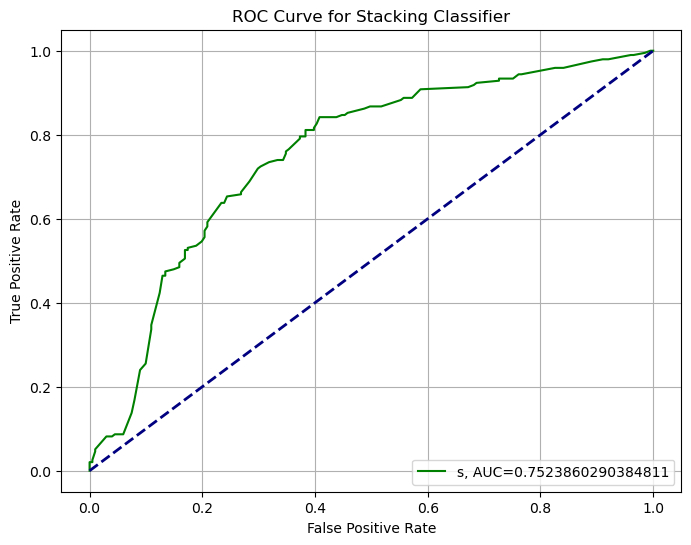

In [476]:
# Calculate predicted probabilities for the positive class (class 1) using Decision Tree
y_pred_proba_s = stacked_classifier.predict_proba(test_standardized_x)[:, 1]

# Calculate the ROC curve
fpr_s, tpr_s, _ = roc_curve(test_standardized_y, y_pred_proba_s)

# Calculate the AUC score
s_auc = roc_auc_score(test_standardized_y, y_pred_proba_s)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label="s, AUC=" + str(s_auc), color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("ROC Curve for Stacking Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

# Deployment

In [ ]:
# pip install spotipy

In [477]:
# Set your Spotify API credentials
client_id = '6291dd76ffb744299366b81b9cddfe5c'
client_secret = '14e1d9b1399a4d8e8ea34e09717b4815'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Set the track ID of the track you want to get features for
# track_id = '7xGfFoTpQ2E7fRF5lN10tr'
track_id = 'https://open.spotify.com/track/1Vk4yRsz0iBzDiZEoFMQyv?si=53b87f6c6f484ec5'
# https://open.spotify.com/track/74jrWagytptonwEtnEQ7BX?si=faeb79bfb2294f65

# Get the track features
track = sp.audio_features(track_id)[0]

# Print the track features
print(f"Acousticness: {track['acousticness']}")
print(f"Danceability: {track['danceability']}")
print(f"Duration: {track['duration_ms']} ms")
print(f"Energy: {track['energy']}")
print(f"Instrumentalness: {track['instrumentalness']}")
print(f"Liveness: {track['liveness']}")
print(f"Loudness: {track['loudness']} dB")
print(f"Speechiness: {track['speechiness']}")
print(f"Tempo: {track['tempo']} BPM")
print(f"Valence: {track['valence']}")
print(f"Mode: {track['mode']}")
print(f"Time signature: {track['time_signature']}")
print(f"Key: {track['key']}")

# Get the track's title and artist
track_info = sp.track(track_id)
print(f"Title: {track_info['name']}")
print(f"Artist: {track_info['artists'][0]['name']}")

Acousticness: 0.976
Danceability: 0.476
Duration: 98040 ms
Energy: 0.192
Instrumentalness: 0.928
Liveness: 0.119
Loudness: -15.753 dB
Speechiness: 0.064
Tempo: 116.542 BPM
Valence: 0.114
Mode: 1
Time signature: 3
Key: 9
Title: Mia & Sebastian’s Theme
Artist: Justin Hurwitz


In [503]:
# Prompt the user for a playlist link
link = input("Enter a Spotify playlist link: ")

# Extract the playlist ID using a regular expression
pattern = r'https://open\.spotify\.com/playlist/(\w+)'
match = re.search(pattern, link)

# Print the playlist ID
if match:
    playlist_id = match.group(1)
    print("Playlist ID:", playlist_id)
else:
    print("Error: Invalid playlist link")

Playlist ID: 1PkLqSEP0rFaw6pw94DZbP


In [504]:
# Set your Spotify API credentials
client_id = '6291dd76ffb744299366b81b9cddfe5c'
client_secret = '14e1d9b1399a4d8e8ea34e09717b4815'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Set the playlist ID and owner ID
# playlist_id = '37i9dQZF1DXdnyffTsenNZ'
# playlist_id = '7gBryLKmZVKEv589tp3ciH'
playlist_id = input("Enter a Spotify Playlist_ID: ")
# owner_id = 'spotify'

# Get the playlist tracks
results = sp.playlist_tracks(playlist_id)
tracks = results['items']

# Print the track IDs
# for track in tracks:
#     print(track['track']['id'], end=',')

print("List of Track ID:")

for i, track in enumerate(tracks):
    if i == len(tracks) - 1:  # Last track
        print(track['track']['id'])
    else:
        print(track['track']['id'], end=',')

List of Track ID:
3xyr2xfbSZiZWWGsjLyMFh,0UMFm4ndFr3PH5VsVYnCNG,5fUzMvyRsUklP0Pdmsh9Mz,5CpafRMWLtB396af979XKR,5q2zRUEMUMh51Ipd97bmAa,5cDmSimrJf4iGm0Mj99pM7,4vg3xQeDwIMwedbnIqa3P4,6JJgmmfMsoGTzwCe2f2K8u,0FKWArXGCU85So3loikCPp,6qIuV4XGihbOG6vYl91sUw,5xvDr5nn3ofCqObkc3Gt5T,3febxmQ2ftM7EUulJXWK7r,77O6okWAa1a7p0kGLs7KlD,26E6EusHnVuneZVE7wJiQ8,33wscN93xwAIS8obMTn6L0,5kLuXO6BmG7hgCs9rS6PkV,1ZtZutPGR7gyprrXxUOFHa,7qEEJ0yuziODsn7CE4Bn99,0A9V6tOEqsKjrJnrWBfPxA,4eRgWKU4AjVKGmtvMbRNXW,0c4XnoxE9xP1qwLjx7F82E,6r3A0vlgi3kFWNwnmKxFRb,3lxViAZ7jeq8N2ovkS6f0Q,3qjImDjgEPaZ94MeBm8nYi,7kGywq6V4lMuOJhZzahpuy,2J6GIqpGaat1AmMkd0zVd2,5V11MVNqBs1ho2vxIREgOl,7ud2U1f9oUrsK96msnWfbO,3Yk0rZxWOETWZcF2EcqhmS,5SAMnnAkOzV8HwQ9CtNrXu,5Y4vRBs4QCUloQ5W9Wb58j,4If7JKEkzeY0WusIrOdQlC,7lYUUqp5hTIiq9f2dDdaSz,22rq6IQa0p9IAxWBaDFut6,0rWyJwte7GCnKDI4b9rCh9,4ZePjigr9RqXs5YwygTVF0,2uiPfEAjXAkEvze2zbkAE2,0CsCzQNqeCEd4NacKr6rE2,6SBAI2JAUvZ3vYKVkB0igS,2UltDQDKUGVQXfRc9Ha4kZ,63y6xWR4gXz7bnUGOk8iI6,0Fc6pAZNzdsX19EMoSyBN7,07UPxtlnFEJnvUAz

In [505]:
# Set your Spotify API credentials
client_id = '6291dd76ffb744299366b81b9cddfe5c'
client_secret = '14e1d9b1399a4d8e8ea34e09717b4815'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Prompt the user for a list of track IDs
track_ids = input("Enter a list of track IDs (separated by commas or new lines): ")
track_ids = re.split(r'[,\n]', track_ids)  # Split on commas and new lines

# Initialize an empty list to store the track features
tracks = []

# Get the track features for each track
for track_id in track_ids:
    # Get the track information from the Spotify API
    track_info = sp.track(track_id)
    
    # Extract the track name and artist name from the track information
    song_title = track_info['name']
    artist = track_info['artists'][0]['name']
    
    # Get the track features from the Spotify API
    try:
        track = sp.audio_features(track_id)[0]
    except TypeError:
        print(f"Error: Unable to get features for track {track_id}")
        continue
    track_data = {
#         'track_id': track_id,
        'acousticness': track['acousticness'],
        'danceability': track['danceability'],
        'duration_ms': track['duration_ms'],
        'energy': track['energy'],
        'instrumentalness': track['instrumentalness'],
        'key': track['key'],
        'liveness': track['liveness'],
        'loudness': track['loudness'],
        'mode': track['mode'],
        'speechiness': track['speechiness'],
        'tempo': track['tempo'],
        'time_signature': track['time_signature'],
        'valence': track['valence'],
        'song_title': song_title,
        'artist': artist
    }
    tracks.append(track_data)

# Create a Pandas dataframe from the list of tracks
df_predict = pd.DataFrame(tracks)

songs = copy.copy(df_predict)

# Print the dataframe
df_predict.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist
0,0.484,0.856,134782,0.656,0.000000,5,0.559,-6.475,1,0.0752,133.927,4,0.949,Hotel,Claire Rosinkranz
1,0.298,0.694,175609,0.637,0.000010,9,0.123,-5.896,1,0.0806,83.982,4,0.506,forever&more,ROLE MODEL
2,0.190,0.836,168849,0.459,0.003290,9,0.318,-9.210,0,0.1130,91.983,4,0.443,Darker Place,Rachel Chinouriri
3,0.219,0.547,206576,0.607,0.000012,3,0.120,-8.536,1,0.0760,183.871,4,0.217,Gravity,Molly Warburton
4,0.295,0.716,156992,0.530,0.000000,8,0.130,-8.275,1,0.2180,93.024,4,0.635,Rocketship,Llunr


# Data Transformation

In [506]:
# Handle unknown labels by assigning them to a special "Unknown" category
df_predict['song_title'] = df_predict['song_title'].apply(lambda x: x if x in known_song_titles else 'Unknown')
df_predict['artist'] = df_predict['artist'].apply(lambda x: x if x in known_artists else 'Unknown')

# Label encoding for 'song_title' and 'artist'
df_predict['song_title'] = le_song_title.transform(df_predict['song_title'])
df_predict['artist'] = le_artist.transform(df_predict['artist'])

In [507]:
#Drop Accousticness, Loudness, Valence
df_predict = df_predict.drop(['acousticness','loudness','valence'], axis=1)
df_predict

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,song_title,artist
0,0.856,134782,0.656,0.000000,5,0.559,1,0.0752,133.927,4,1768,1252
1,0.694,175609,0.637,0.000010,9,0.123,1,0.0806,83.982,4,1768,1252
2,0.836,168849,0.459,0.003290,9,0.318,0,0.1130,91.983,4,1768,1252
3,0.547,206576,0.607,0.000012,3,0.120,1,0.0760,183.871,4,1768,1252
4,0.716,156992,0.530,0.000000,8,0.130,1,0.2180,93.024,4,1768,1252
...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.751,194133,0.486,0.038000,1,0.108,1,0.0372,120.014,4,1768,1252
94,0.710,146484,0.831,0.005690,0,0.349,1,0.0299,129.021,4,1768,1252
95,0.710,177415,0.342,0.599000,6,0.139,1,0.0651,173.050,4,1768,1252
96,0.592,188143,0.733,0.201000,5,0.591,1,0.0544,104.977,4,1768,1252


In [508]:
# Load the saved scaler object
scaler = joblib.load('standard_scaler.pkl')
# Scaling
columns_to_standardize = ['instrumentalness', 'danceability', 'duration_ms', 'energy', 'speechiness', 'liveness', 'tempo']
df_predict[columns_to_standardize] = scaler.transform(df_predict[columns_to_standardize])
#print
df_predict

,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,time_signature,song_title,artist
0,1.480070,-1.364227,-0.128615,-0.487360,5,2.376811,1,-0.194225,0.457764,4,1768,1252
1,0.471698,-0.861859,-0.219032,-0.487325,9,-0.433350,1,-0.133854,-1.412698,4,1768,1252
2,1.355580,-0.945039,-1.066099,-0.475300,9,0.823488,0,0.228378,-1.113057,4,1768,1252
3,-0.443307,-0.480816,-0.361797,-0.487318,3,-0.452686,1,-0.185281,2.328190,4,1768,1252
4,0.608637,-1.090937,-0.728224,-0.487360,8,-0.388233,1,1.402276,-1.074071,4,1768,1252
...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.826495,-0.633924,-0.937612,-0.348063,1,-0.530030,1,-0.619065,-0.063284,4,1768,1252
94,0.571290,-1.220236,0.704175,-0.466503,0,1.023293,1,-0.700679,0.274033,4,1768,1252
95,0.571290,-0.839636,-1.622879,1.708405,6,-0.330225,1,-0.307143,1.922938,4,1768,1252
96,-0.163204,-0.707630,0.237813,0.249449,5,2.583061,1,-0.426769,-0.626426,4,1768,1252


#### Read model and Predict new data

In [517]:
# Load the model from the file
# newModel = joblib.load('xgb_Model.pkl')
# newModel = joblib.load('stacked_classifier.pkl')
# newModel = joblib.load('rf_model.pkl')
newModel = joblib.load('gnb_model.pkl')


# Make predictions on new data
# X=df.drop('track_id',axis=True)
X=df_predict
predictions = newModel.predict(X)

# predictions

In [518]:
# Create dataframe with the song_title, artist, and predicted labels
df_predictions = pd.DataFrame({
    'song_title': songs['song_title'],
    'artist': songs['artist'],
    'target': predictions
})

count_0 = df_predictions['target'].value_counts()[0]
count_1 = df_predictions['target'].value_counts()[1]


# Print count and dataframe
print('Liked Songs Predicted:', count_1)
print('Not Liked Songs Predicted:', count_0)
df_predictions

Liked Songs Predicted: 24
Not Liked Songs Predicted: 74


,song_title,artist,target
0,Hotel,Claire Rosinkranz,1
1,forever&more,ROLE MODEL,0
2,Darker Place,Rachel Chinouriri,1
3,Gravity,Molly Warburton,0
4,Rocketship,Llunr,1
...,...,...,...
93,Kenny,Still Woozy,0
94,Courtside,Tim Atlas,0
95,Drive Slow,Calica,0
96,FEEL LIKE,Josh Fudge,1
